In [1]:
import uproot
import matplotlib.pyplot as plt
import scipy as scp
from scipy.optimize import curve_fit 
from scipy.integrate import trapezoid
import numpy as np
import awkward as ak
from lmfit.models import GaussianModel, ExponentialModel, \
                         ThermalDistributionModel, StepModel #Modelli vari, l'ultimo è Fermi (o Bose)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Fit completo

In [2]:
def load_histo(dat_PATH):
    data = np.loadtxt(dat_PATH, skiprows=0, comments='==')
    noises_edges = np.zeros((int(data.shape[0]/2), data.shape[1]))       
    noises_values = np.zeros((int(data.shape[0]/2), data.shape[1]))      

    for i in range(int(data.shape[0]/2)):
        noises_edges[i] = (data[2 * i])
        noises_values[i] = (data[2 * i + 1])

    return noises_edges, noises_values


def rebin(data, factor):
    if len(data) % factor != 0:
        raise ValueError("Length of data must be divisible by factor.")
    rebinned_data = np.sum(data.reshape(-1, factor), axis=1)
    return rebinned_data

PATH="../Dati/linearity/Run_Ba_30_2000_ChargeHistos_5_16_2024_2.dat"
channel=2
channel_idx = np.arange(0,16, step=1)

In [3]:
edge_N, bin_N = load_histo(PATH)
edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1

#if channel == 5:
    #rebin_fact = 2


bin_N = rebin(bin_N, rebin_fact)
tmp = []



for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)

In [4]:
lim_list = [[-575, -460],  #ch0
            [-110, -55],      #ch1      #èsbaglaito
            [-1600, -50],  #ch2
            [-1200, -1000],  #ch3
            [-825, -700],  #ch4
            [-1400, -1160],  #ch5
            [-920, -775],  #ch6
            [-1350, -1110],  #ch7
            [-1060, -880],  #ch8
            [-550, -435],  #ch9
            [-490, -400],  #ch10
            [-900, -700],  #ch11
            [-800, -620],      #ch12
            [-1240, -1010],      #ch13
            [-1250, -1000],  #ch14
            [-1700, -1500]   #ch15
            ]


lim_N = lim_list[channel]
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

Text(0, 0.5, 'counts')

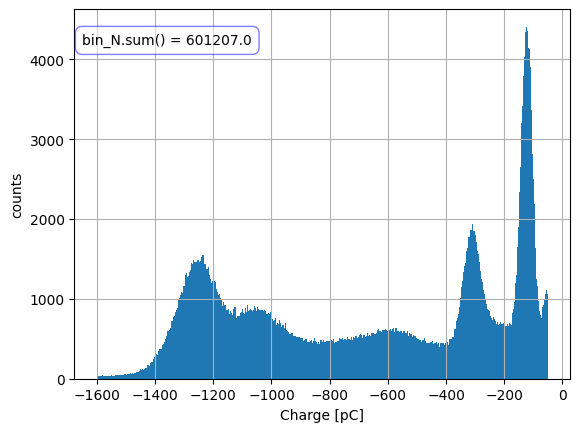

In [5]:
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))

plt.bar(centers_N, bin_N, width = 4)
#plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

In [6]:
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
gauss1 = GaussianModel(prefix='g1_')    #Gaussiana
gauss2 = GaussianModel(prefix='g2_')    #Gaussiana
gauss3 = GaussianModel(prefix='g3_')    #Gaussiana
gauss4 = GaussianModel(prefix='g4_')    #Gaussiana
gauss5 = GaussianModel(prefix='g5_')    #Gaussiana
#sigmoid1 = StepModel(form = "logistic", prefix = "s1_") #Sigmoide
#sigmoid2 = StepModel(form = "logistic", prefix = "s2_") #Sigmoide
#sigmoid3 = StepModel(form = "logistic", prefix = "s3_") #Sigmoide



params = exp1.guess(bin_N, x=centers_N)           #Inizializzo i parametri dell'esponenziale
#params.update(sigmoid1.guess(bin_N, x=centers_N))
params.update(gauss1.make_params(amplitude = 5500, center = -610, sigma = 20))   
params.update(gauss2.make_params(amplitude = 5500, center = -540, sigma = 20)) 
params.update(gauss3.make_params(amplitude = 5500, center = -610, sigma = 20))   
params.update(gauss4.make_params(amplitude = 5500, center = -540, sigma = 20)) 
params.update(gauss5.make_params(amplitude = 5500, center = -610, sigma = 20))   

params["g1_amplitude"].min = 0
params["g1_center"].set(value=-600)
params["g2_center"].set(value=-122.249)
params["g3_center"].set(value= -309.287)
params["g4_center"].set(value=-1064.259)
params["g5_center"].set(value=-1245.953)
params["g2_amplitude"].min = 0  



params["e1_decay"].value = -140
params["e1_amplitude"].value = 914



#-1673.738, -4043.482, -122.249, -309.287, -1064.259,  -1245.953



model = exp1 + gauss1 + gauss2 + gauss3 + gauss4 + gauss5#+ sigmoid1 + sigmoid2 #+ sigmoid3

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


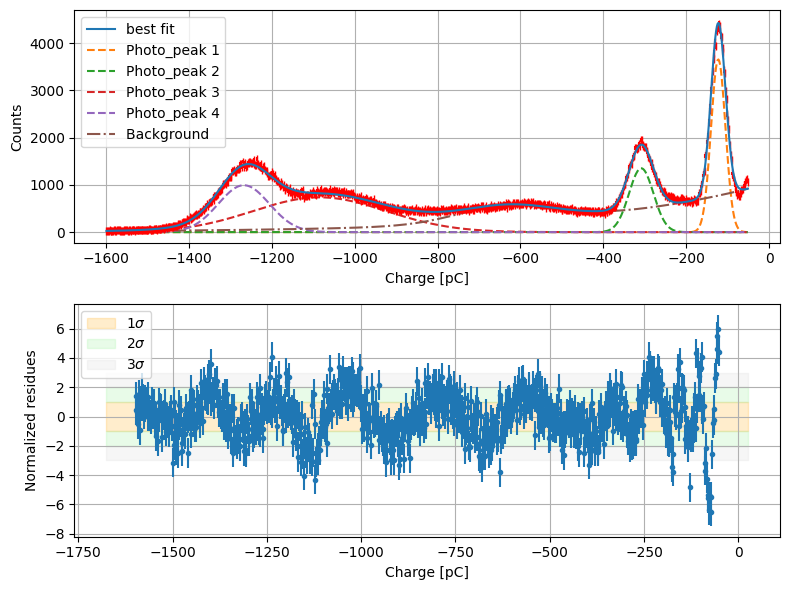

[[Model]]
    (((((Model(exponential, prefix='e1_') + Model(gaussian, prefix='g1_')) + Model(gaussian, prefix='g2_')) + Model(gaussian, prefix='g3_')) + Model(gaussian, prefix='g4_')) + Model(gaussian, prefix='g5_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 291
    # data points      = 786
    # variables        = 17
    chi-square         = 2085.48677
    reduced chi-square = 2.71194639
    Akaike info crit   = 800.979413
    Bayesian info crit = 880.317678
    R-squared          = 0.99441582
[[Variables]]
    e1_amplitude:  1041.99650 +/- 15.1182380 (1.45%) (init = 914)
    e1_decay:     -411.329366 +/- 10.9650558 (2.67%) (init = -140)
    g1_amplitude:  102680.319 +/- 3501.77308 (3.41%) (init = 5500)
    g1_center:    -633.069575 +/- 2.59314164 (0.41%) (init = -600)
    g1_sigma:      117.143944 +/- 2.77392985 (2.37%) (init = 20)
    g1_fwhm:       275.852903 +/- 6.53210550 (2.37%) == '2.3548200*g1_sigma'
    g1_height:     349.685363 +/- 7.371003

In [8]:
result = model.fit(bin_N, params, x = centers_N, weights = 1 / err_N)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

#_ = ax1.hist(bin_N, range = lim_N, color = "cyan", alpha = 0.5, label = "Dati sperimentali")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()  

#Plotto il best fit + le componenti
ax1.plot(centers_N, result.best_fit, label='best fit', zorder = 10)
#ax1.plot(centers_N, comps['g1_'], label='', ls = "--")
#ax1.plot(centers_N, comps['s2_'], label='Compton 1', ls = "--")
ax1.plot(centers_N, comps['g2_'], label='Photo_peak 1', ls = "--")
ax1.plot(centers_N, comps['g3_'], label='Photo_peak 2', ls = "--")

ax1.plot(centers_N, comps['g5_'], label='Photo_peak 3', ls = "--")
ax1.plot(centers_N, comps['g4_'], label='Photo_peak 4', ls = "--")
#ax1.plot(centers_N, comps['s3_'], label='Compton 2', ls = "--")

#ax1.plot(centers_N, comps['e1_'] + comps['s1_'], label='Background')
ax1.plot(centers_N, comps['e1_'] + comps['g1_'], label='Background ', ls = "-.")
#ax1.plot(centers_N, comps['s1_'], label='Background FD', ls = "-.")

ax1.legend()
ax1.errorbar(centers_N, bin_N, err_N, color = "red", fmt='|')
ax1.grid()

residueCs = bin_N - result.best_fit
norm_resCs = residueCs / err_N

ax2.errorbar(centers_N, norm_resCs, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.savefig('fit_bario.png')
plt.show()
print(result.fit_report())


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


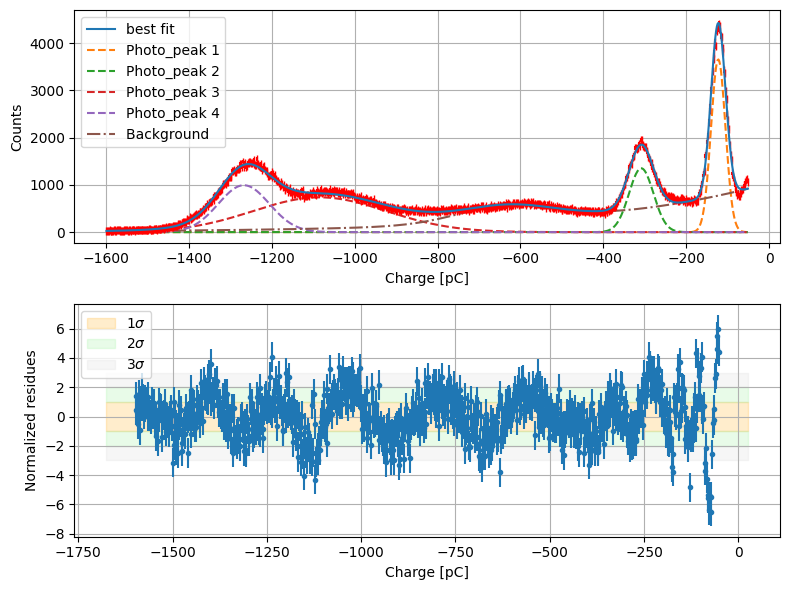

[[Model]]
    (((((Model(exponential, prefix='e1_') + Model(gaussian, prefix='g1_')) + Model(gaussian, prefix='g2_')) + Model(gaussian, prefix='g3_')) + Model(gaussian, prefix='g4_')) + Model(gaussian, prefix='g5_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 291
    # data points      = 786
    # variables        = 17
    chi-square         = 2085.48677
    reduced chi-square = 2.71194639
    Akaike info crit   = 800.979413
    Bayesian info crit = 880.317678
    R-squared          = 0.99441582
[[Variables]]
    e1_amplitude:  1041.99650 +/- 15.1182380 (1.45%) (init = 914)
    e1_decay:     -411.329366 +/- 10.9650558 (2.67%) (init = -140)
    g1_amplitude:  102680.319 +/- 3501.77308 (3.41%) (init = 5500)
    g1_center:    -633.069575 +/- 2.59314164 (0.41%) (init = -600)
    g1_sigma:      117.143944 +/- 2.77392985 (2.37%) (init = 20)
    g1_fwhm:       275.852903 +/- 6.53210550 (2.37%) == '2.3548200*g1_sigma'
    g1_height:     349.685363 +/- 7.371003

<Figure size 640x480 with 0 Axes>

In [118]:
result = model.fit(bin_N, params, x = centers_N, weights = 1 / err_N)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

#_ = ax1.hist(bin_N, range = lim_N, color = "cyan", alpha = 0.5, label = "Dati sperimentali")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centers_N, result.best_fit, label='best fit', zorder = 10)
#ax1.plot(centers_N, comps['g1_'], label='', ls = "--")
#ax1.plot(centers_N, comps['s2_'], label='Compton 1', ls = "--")
ax1.plot(centers_N, comps['g2_'], label='Photo_peak 1', ls = "--")
ax1.plot(centers_N, comps['g3_'], label='Photo_peak 2', ls = "--")

ax1.plot(centers_N, comps['g5_'], label='Photo_peak 3', ls = "--")
ax1.plot(centers_N, comps['g4_'], label='Photo_peak 4', ls = "--")
#ax1.plot(centers_N, comps['s3_'], label='Compton 2', ls = "--")

#ax1.plot(centers_N, comps['e1_'] + comps['s1_'], label='Background')
ax1.plot(centers_N, comps['e1_'] + comps['g1_'], label='Background ', ls = "-.")
#ax1.plot(centers_N, comps['s1_'], label='Background FD', ls = "-.")

ax1.legend()
ax1.errorbar(centers_N, bin_N, err_N, color = "red", fmt='|')
ax1.grid()

residueCs = bin_N - result.best_fit
norm_resCs = residueCs / err_N

ax2.errorbar(centers_N, norm_resCs, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()
print(result.fit_report())
plt.savefig('fit_bario.png')

In [128]:
peak_f=np.abs(np.array([-1216.816, -1142.936, -4043.482, -2679.389, -1825.805, -3077.995, -2076.421, -2938.099, -2288.095, -1217.833,
       -1056.445, -1899.582, -1726.943, -2728.146, -2700.407, -3837.629] ))
channel_ref=2

In [132]:
diff_rel=(gau-compl)/compl
#err_diff_rel=s_g/gau + s_c/compl
print(diff_rel)

[-0.00725985  0.00130146 -0.01841138 -0.01653406]


[ 0.05575056 -1.51336983] 0.017347673603274834 1.4994970750468353
[ 0.894 -0.402 19.962 20.947]


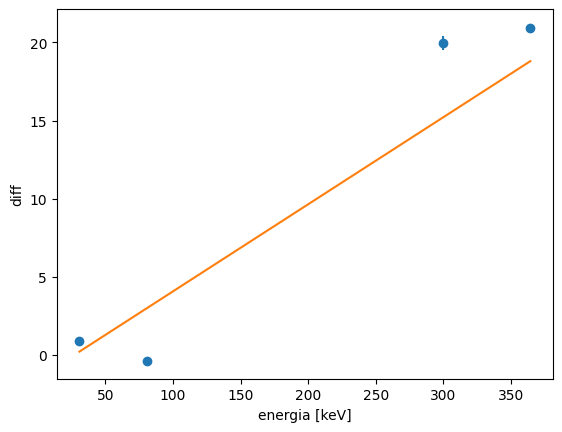

In [130]:

ref_g=peak_f[channel_ref]
energia=511/ref_g
gau=np.array([-122.249, -309.287, -1064.259,  -1245.953])#*energia
s_g=np.array([0.141, 0.226, 2.641, 0.493])*energia
compl=np.array([-123.143, -308.885, -1084.221, -1266.900])#*energia
s_c=np.array([0.141, 0.34, 2.693 ,0.723])*energia
diff=gau-compl
en=np.array([30.85, 81, (276.4*0.088+302.85*0.666)/(0.088+0.666), (356.02*0.738+383.9*0.317)/(0.317+0.738)])
par, cov= curve_fit(retta, en, diff, sigma=np.sqrt(s_g**2+s_c**2))
print(par, np.sqrt(cov[0][0]), np.sqrt(cov[1][1]))
plt.errorbar(en, diff, yerr=np.sqrt(s_g**2+s_c**2), linestyle=' ', marker='o')
plt.plot(en, retta(en, par[0], par[1]))
plt.xlabel('energia [keV]')
plt.ylabel('diff')
print(diff)

# Peak estimation

In [2]:
def load_histo(dat_PATH):
    data = np.loadtxt(dat_PATH, skiprows=0, comments='==')
    noises_edges = np.zeros((int(data.shape[0]/2), data.shape[1]))       
    noises_values = np.zeros((int(data.shape[0]/2), data.shape[1]))      

    for i in range(int(data.shape[0]/2)):
        noises_edges[i] = (data[2 * i])
        noises_values[i] = (data[2 * i + 1])

    return noises_edges, noises_values


def rebin(data, factor):
    if len(data) % factor != 0:
        raise ValueError("Length of data must be divisible by factor.")
    rebinned_data = np.sum(data.reshape(-1, factor), axis=1)
    return rebinned_data
#PATH_MARTI="../Dati/Run_chall_ChargeHistos_4_12_2024_10M.dat"


In [3]:
#per il sodio
ch_1=[0,1,4,11,12, 6]
ch_2=[2,15]
ch_3=[3,5,7,13,14]
ch_4=[9,10]

In [4]:
#per il bario
ch_1=[0, ]

In [374]:
channel=15

In [387]:
#PATH="../Dati/Run_Ba_50_1000_ChargeHistos_5_16_2024.dat"
#PATH="../Dati/linearity/Run_2M_50_2000_ChargeHistos_5_10_2024.dat"

#PATH="../Dati/linearity/Run_Ba_40_600_ChargeHistos_5_16_2024.dat"
#PATH="../Dati/linearity/Run_Ba_30_1000_ChargeHistos_5_16_2024.dat" #ch 3 5 6 7
#PATH="../Dati/linearity/Run_30_600_ChargeHistos_5_16_2024_2.dat" #ch 4 9 10 11 12
#PATH="../Dati/linearity/Run_30_1000_ChargeHistos_5_16_2024_2.dat" # ch 14
#PATH='../Dati/linearity/Run_Ba_50_1000_ChargeHistos_5_16_2024.dat' #ch 8
#PATH='../Dati/linearity/Run_Ba_100_2000_ChargeHistos_5_16_2024.dat'  #
PATH="../Dati/linearity/Run_Ba_30_2000_ChargeHistos_5_16_2024_2.dat"  #ch 2 15
#if channel==8:
    #PATH="../Dati/linearity/Run_ch8_ChargeHistos_5_10_2024.dat"
edge_N, bin_N = load_histo(PATH)#, usecols=(0,1,2,3,4,5,6))
#edge_N, bin_N = np.loadtxt(PATH, usecols=(0,1,2,3,4,5,6))


channel_idx = np.arange(0,16, step=1)

# Na peak

## Peak e+e-

In [145]:
edge_N, bin_N = load_histo(PATH)
edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1

#if channel == 5:
    #rebin_fact = 2


bin_N = rebin(bin_N, rebin_fact)
tmp = []



for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)

In [ ]:
edge_N, bin_N = load_histo(PATH)
edge_N = edge_N[0]
bin_N = bin_N[0]

rebin_fact = 1

#if channel == 5:
    #rebin_fact = 2


bin_N = rebin(bin_N, rebin_fact)
tmp = []



for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)

In [40]:
lim_list = [[-575, -460],  #ch0
            [-110, -55],      #ch1      #èsbaglaito
            [-1850, -1550],  #ch2
            [-1200, -1000],  #ch3
            [-825, -700],  #ch4
            [-1400, -1160],  #ch5
            [-920, -775],  #ch6
            [-1350, -1110],  #ch7
            [-1060, -880],  #ch8
            [-550, -435],  #ch9
            [-490, -400],  #ch10
            [-900, -700],  #ch11
            [-800, -620],      #ch12
            [-1240, -1010],      #ch13
            [-1250, -1000],  #ch14
            [-1700, -1500]   #ch15
            ]


lim_N = lim_list[channel]
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

Text(0, 0.5, 'counts')

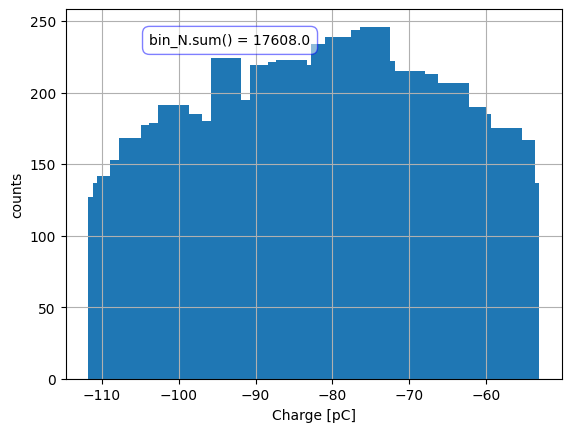

In [41]:
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))

plt.bar(centers_N, bin_N, width = 4)
#plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

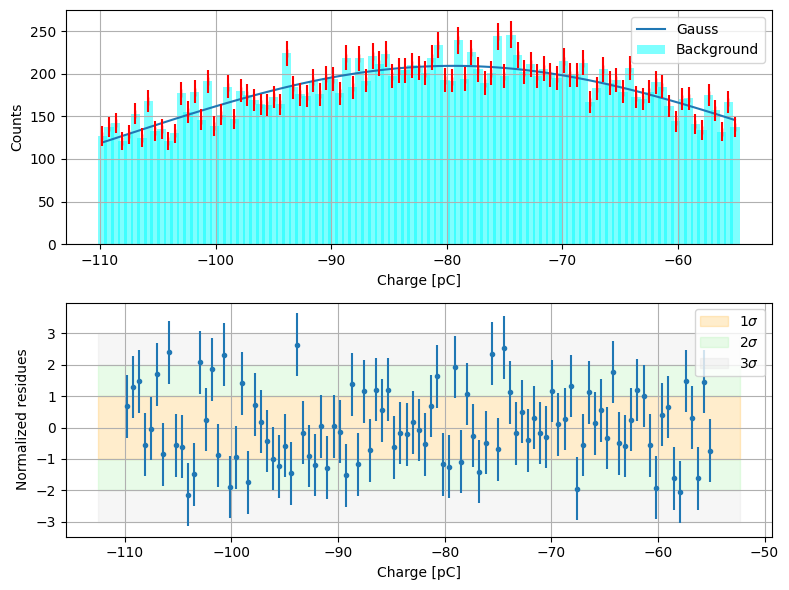

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 97
    # variables        = 3
    chi-square         = 135.713642
    reduced chi-square = 1.44376215
    Akaike info crit   = 38.5761032
    Bayesian info crit = 46.3002361
    R-squared          = 0.71416978
[[Variables]]
    g3_amplitude:  15022.0024 +/- 405.333619 (2.70%) (init = 7374.375)
    g3_center:    -79.4549337 +/- 0.52663937 (0.66%) (init = -78.9288)
    g3_sigma:      28.6398551 +/- 0.98991516 (3.46%) (init = 19.665)
    g3_fwhm:       67.4417035 +/- 2.33107201 (3.46%) == '2.3548200*g3_sigma'
    g3_height:     209.250787 +/- 2.71926373 (1.30%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma)  = +0.9403
    C(g3_amplitude, g3_center) = +0.3522
    C(g3_center, g3_sigma)     = +0.3255


In [42]:
#picco del fotoelettrico

sist_lims = lim_N
sist_bin = bin_N
sist_cntr = centers_N
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())

## f peak

In [244]:
channel=15

In [245]:
if channel in ch_1:
    PATH_SAM="../Dati/Run_1M_50_3000_ChargeHistos_5_10_2024.dat"
elif channel in ch_2:
    PATH_SAM="../Dati/Run_2M_50_5000_ChargeHistos_5_10_2024.dat"
elif channel in ch_3:
    PATH_SAM="../Dati/Run_2M_50_4000_ChargeHistos_5_10_2024.dat"
elif channel in ch_4:
    PATH_SAM="../Dati/Run_2M_50_2000_ChargeHistos_5_10_2024.dat"
if channel==8:
    PATH_SAM="../Dati/Run_ch8_ChargeHistos_5_10_2024.dat"


#PATH_SAM="../Dati/Run_2M_50_2000_ChargeHistos_5_10_2024.dat"
edge_N, bin_N = load_histo(PATH_SAM)



channel_idx = np.arange(0,16, step=1)

In [246]:
edge_N, bin_N = load_histo(PATH_SAM)
edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1

#if channel == 5:
    #rebin_fact = 2


bin_N = rebin(bin_N, rebin_fact)
tmp = []

for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)

In [256]:
lim_list = [[-1345, -1127],  #ch0
            [-1250, -1040],      #ch1
            [-4400, -3750],  #ch2
            [-2950, -2550],  #ch3
            [-2000, -1700],  #ch4
            [-3390, -2800],  #ch5
            [-2300, -1900],  #ch6
            [-3200, -2700],  #ch7
            [-2450, -2155],  #ch8
            [-1350, -1100],  #ch9
            [-1150, -1000],  #ch10
            [-2100, -1750],  #ch11
            [-1900, -1600],      #ch12
            [-3000, -2500],      #ch13
            [-3000, -3500],  #ch14
            [-4200, -3500]   #ch15
            ]


lim_N = lim_list[channel]
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

Text(0, 0.5, 'counts')

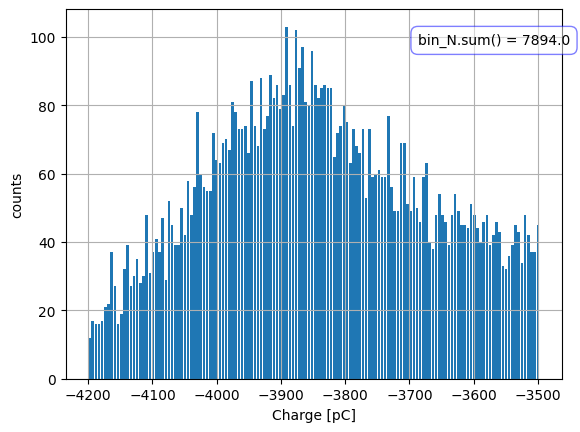

In [257]:
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))

plt.bar(centers_N, bin_N, width = 4)
#plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

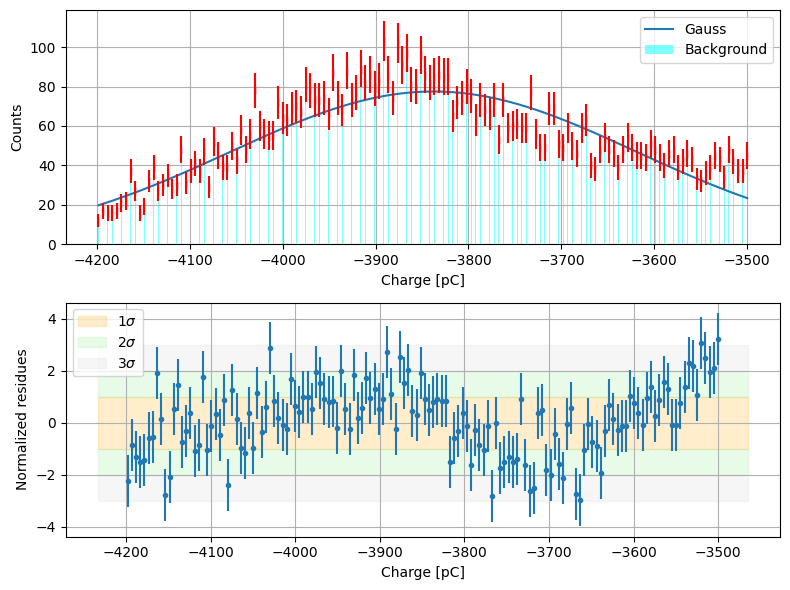

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 142
    # variables        = 3
    chi-square         = 258.582067
    reduced chi-square = 1.86030264
    Akaike info crit   = 91.1128206
    Bayesian info crit = 99.9803018
    R-squared          = 0.76683852
[[Variables]]
    g3_amplitude:  42348.5545 +/- 776.936964 (1.83%) (init = 50675.62)
    g3_center:    -3837.62880 +/- 4.46804932 (0.12%) (init = -3864.407)
    g3_sigma:      218.068390 +/- 5.29597928 (2.43%) (init = 185.625)
    g3_fwhm:       513.511806 +/- 12.4710779 (2.43%) == '2.3548200*g3_sigma'
    g3_height:     77.4739967 +/- 1.65901533 (2.14%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma)  = +0.5250
    C(g3_center, g3_sigma)     = +0.2080
    C(g3_amplitude, g3_center) = +0.1314


In [258]:
#picco del fotoelettrico

sist_lims = lim_N
sist_bin = bin_N
sist_cntr = centers_N
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())

## conclusions

In [38]:
peak_e=np.abs(np.array([-506.734, -461.730, -1673.738, -1085.422, -758.996, -1258.207, -854.866, -1216.707, -948.590, -506.800,
       -437.591, -776.004, -705.231, -1121.940, -1111.193, -1593.873]))
sigma_e=np.array([0.715, 0.789, 0.664, 0.844, 0.620, 1.360, 0.91, 1.116, 0.613, 1.236, 
         0.469, 0.955, 1.196, 0.961, 1.043, 1.558])
peak_f=np.abs(np.array([-1216.816, -1142.936, -4043.482, -2679.389, -1825.805, -3077.995, -2076.421, -2938.099, -2288.095, -1217.833,
       -1056.445, -1899.582, -1726.943, -2728.146, -2700.407, -3837.629] ))
sigma_f=np.array([1.615, 1.780, 2.493, 3.325, 1.683, 3.790, 2.369, 3.218, 1.281, 1.511,
        0.967, 2.157, 2.608, 2.609, 2.604, 4.468])

In [42]:
peak_e[14]

1111.193

# Ba peaks

## peak 1

In [391]:
edge_N, bin_N = load_histo(PATH)
edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1

#if channel == 5:
    #rebin_fact = 2


bin_N = rebin(bin_N, rebin_fact)
tmp = []

for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)

In [399]:
lim_list = [[-450, -80],  #ch0
            [-110, -50],      #ch1      #rispetto a prima è cambiato un sacco :(
            [-150, -90],  #ch2
            [-108, -55],  #ch3  #108 55
            [-70, -45],  #ch4
            [-110, -40],  #ch5
            [-80, -50],  #ch6
            [-110, -50],  #ch7
            [-230, -85],  #ch8
            [-125, -70],  #ch9
            [-100, -50],  #ch10
            [-150, -100],  #ch11
            [-180, -100],      #ch12
            [-10, -50],      #ch13
            [-97, -30],  #ch14
            [-150, -75]   #ch15
            ]


lim_N = lim_list[channel]
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

Text(0, 0.5, 'counts')

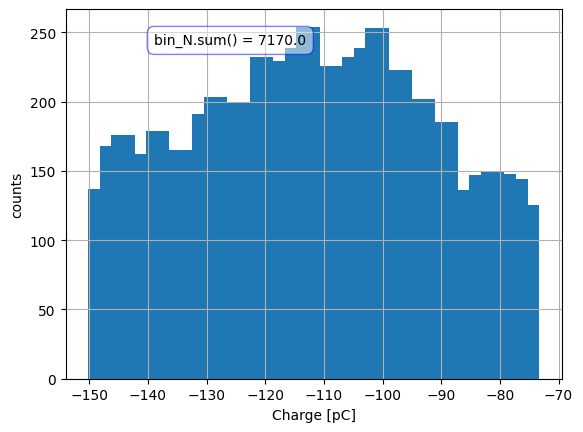

In [400]:
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))

plt.bar(centers_N, bin_N, width = 4)
#plt.xlim(lim_N)
plt.grid()

plt.xlabel("Charge [pC]")
plt.ylabel("counts")


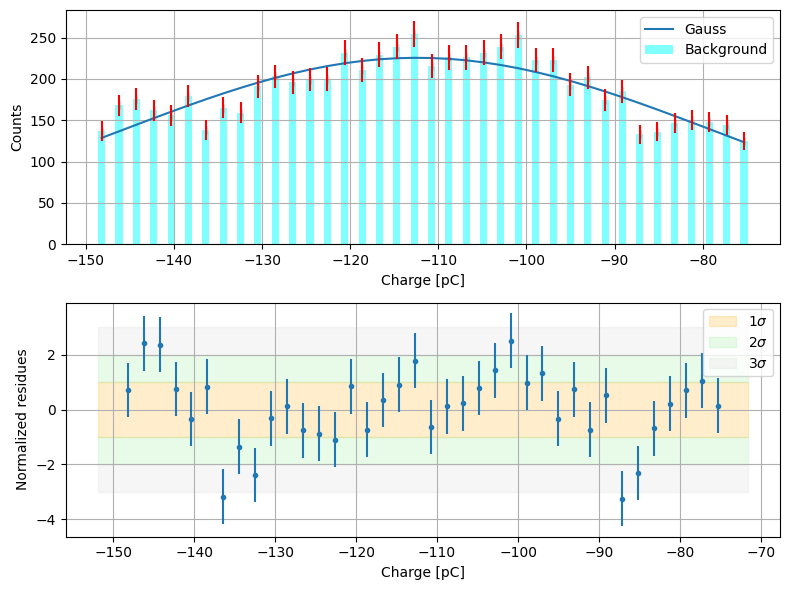

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 38
    # variables        = 3
    chi-square         = 70.8406062
    reduced chi-square = 2.02401732
    Akaike info crit   = 29.6681560
    Bayesian info crit = 34.5809145
    R-squared          = 0.76193906
[[Variables]]
    g3_amplitude:  19102.7638 +/- 710.811406 (3.72%) (init = 7242.705)
    g3_center:    -112.396862 +/- 0.97316651 (0.87%) (init = -111.755)
    g3_sigma:      33.7821943 +/- 1.71217674 (5.07%) (init = 18.715)
    g3_fwhm:       79.5509868 +/- 4.03186805 (5.07%) == '2.3548200*g3_sigma'
    g3_height:     225.589269 +/- 5.49076079 (2.43%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma) = +0.8911


In [401]:
#picco del fotoelettrico

sist_lims = lim_N
sist_bin = bin_N
sist_cntr = centers_N
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())

## peak 2

In [405]:
edge_N, bin_N = load_histo(PATH)
edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1

#if channel == 5:
    #rebin_fact = 2


bin_N = rebin(bin_N, rebin_fact)
tmp = []

for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)

In [410]:
lim_list = [[-575, -460],  #ch0
            [-400, -300],      #ch1      #rispetto a prima è cambiato un sacco :(
            [-360, -270],  #ch2
            [-220, -140],  #ch3
            [-160, -100],  #ch4
            [-300, -110],  #ch5
            [-180, -100],  #ch6
            [-330, -110],  #ch7
            [-800, -625],  #ch8
            [-450, -340],  #ch9
            [-370, -300],  #ch10
            [-600, -520],  #ch11
            [-800, -480],      #ch12
            [-1240, -1010],      #ch13
            [-235, -145],  #ch14
            [-325, -225]   #ch15
            ]


lim_N = lim_list[channel]
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

Text(0, 0.5, 'counts')

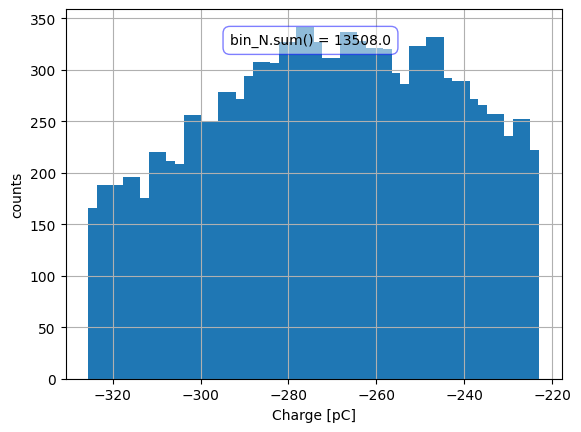

In [411]:
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))

plt.bar(centers_N, bin_N, width = 4)
#plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

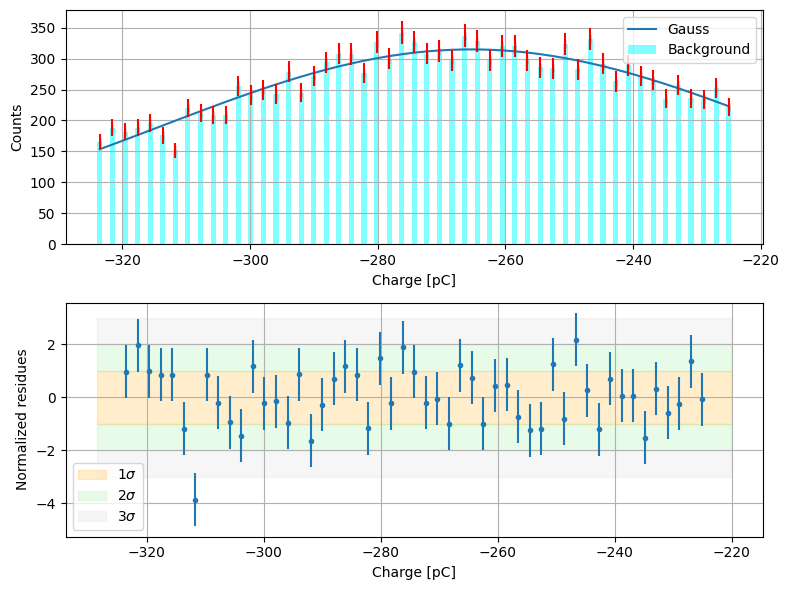

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 51
    # variables        = 3
    chi-square         = 65.5074644
    reduced chi-square = 1.36473884
    Akaike info crit   = 18.7672616
    Bayesian info crit = 24.5627385
    R-squared          = 0.87187721
[[Variables]]
    g3_amplitude:  38325.6580 +/- 1013.44307 (2.64%) (init = 21335.1)
    g3_center:    -265.352941 +/- 1.02069024 (0.38%) (init = -264.5494)
    g3_sigma:      48.5638701 +/- 1.64974746 (3.40%) (init = 37.43)
    g3_fwhm:       114.359173 +/- 3.88485832 (3.40%) == '2.3548200*g3_sigma'
    g3_height:     314.837473 +/- 4.44876002 (1.41%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma)  = +0.9204
    C(g3_amplitude, g3_center) = +0.5367
    C(g3_center, g3_sigma)     = +0.5008


In [412]:
#picco del fotoelettrico

sist_lims = lim_N
sist_bin = bin_N
sist_cntr = centers_N
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())

## peak 3

In [416]:
edge_N, bin_N = load_histo(PATH)
edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1

#if channel == 5:
    #rebin_fact = 2


bin_N = rebin(bin_N, rebin_fact)
tmp = []

for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)

In [419]:
lim_list = [[-575, -460],  #ch0
            [-530, -425],      #ch1      #rispetto a prima è cambiato un sacco :(
            [-1120, -900],  #ch2
            [-700, -500],  #ch3
            [-477, -350],  #ch4
            [-800, -600],  #ch5
            [-530, -400],  #ch6
            [-800, -600],  #ch7
            [-1060, -880],  #ch8
            [-550, -435],  #ch9
            [-490, -400],  #ch10
            [-900, -700],  #ch11
            [-800, -620],      #ch12
            [-1240, -1010],      #ch13
            [-890, -720],  #ch14
            [-1000, -800]   #ch15
            ]


lim_N = lim_list[channel]
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

Text(0, 0.5, 'counts')

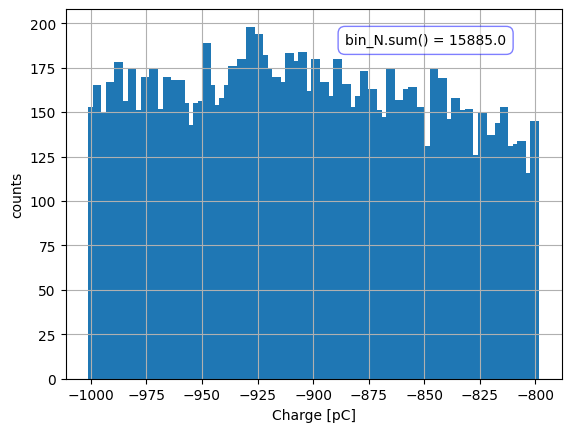

In [420]:
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))

plt.bar(centers_N, bin_N, width = 4)
#plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

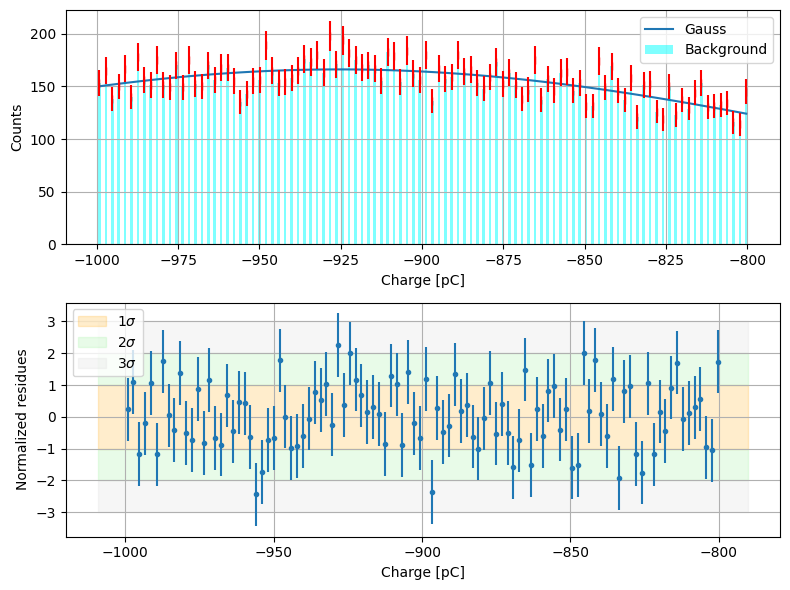

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 102
    # variables        = 3
    chi-square         = 109.689219
    reduced chi-square = 1.10797191
    Akaike info crit   = 13.4131842
    Bayesian info crit = 21.2881026
    R-squared          = 0.44434597
[[Variables]]
    g3_amplitude:  68248.4976 +/- 4760.39502 (6.98%) (init = 20354.04)
    g3_center:    -925.429215 +/- 5.44998394 (0.59%) (init = -915.772)
    g3_sigma:      163.825226 +/- 12.5494926 (7.66%) (init = 80.77)
    g3_fwhm:       385.778919 +/- 29.5517962 (7.66%) == '2.3548200*g3_sigma'
    g3_height:     166.196704 +/- 1.94394272 (1.17%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma)  = +0.9916
    C(g3_amplitude, g3_center) = -0.7125
    C(g3_center, g3_sigma)     = -0.6831


In [421]:
#picco del fotoelettrico

sist_lims = lim_N
sist_bin = bin_N
sist_cntr = centers_N
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())

## Peak 4


In [425]:
edge_N, bin_N = load_histo(PATH)
edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1

#if channel == 5:
    #rebin_fact = 2


bin_N = rebin(bin_N, rebin_fact)
tmp = []

for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)

In [431]:
lim_list = [[-420, -340],  #ch0
            [-530, -425],      #ch1      #rispetto a prima è cambiato un sacco :(
            [-1395, -1160],  #ch2
            [-900, -700],  #ch3
            [-600, -477],  #ch4
            [-1000, -800],  #ch5
            [-675, -543],  #ch6
            [-975, -800],  #ch7
            [-1060, -880],  #ch8
            [-550, -435],  #ch9
            [-490, -400],  #ch10
            [-900, -700],  #ch11
            [-800, -620],      #ch12
            [-1240, -1010],      #ch13
            [-1250, -1000],  #ch14
            [-1250, -1000]   #ch15
            ]


lim_N = lim_list[channel]
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

Text(0, 0.5, 'counts')

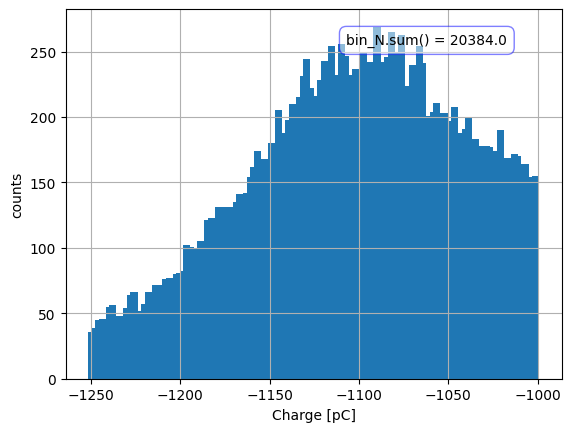

In [432]:
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))

plt.bar(centers_N, bin_N, width = 4)
#plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

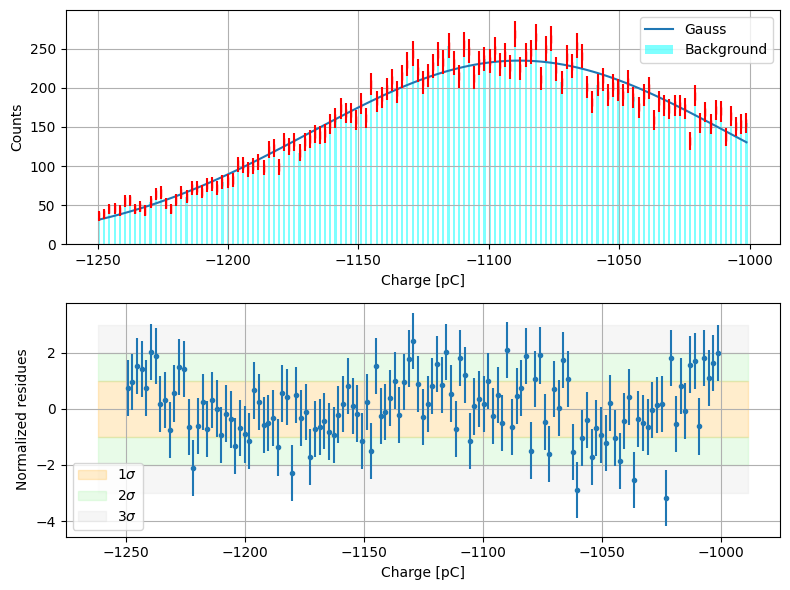

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 127
    # variables        = 3
    chi-square         = 165.326910
    reduced chi-square = 1.33328153
    Akaike info crit   = 39.4946881
    Bayesian info crit = 48.0272493
    R-squared          = 0.95089480
[[Variables]]
    g3_amplitude:  47312.2868 +/- 528.547755 (1.12%) (init = 55769.72)
    g3_center:    -1088.38174 +/- 1.11430868 (0.10%) (init = -1083.601)
    g3_sigma:      80.3462588 +/- 1.11278712 (1.38%) (init = 79.785)
    g3_fwhm:       189.200977 +/- 2.62041337 (1.38%) == '2.3548200*g3_sigma'
    g3_height:     234.919121 +/- 2.49411502 (1.06%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma)  = +0.6589
    C(g3_center, g3_sigma)     = +0.6147
    C(g3_amplitude, g3_center) = +0.5576


In [433]:
#picco del fotoelettrico

sist_lims = lim_N
sist_bin = bin_N
sist_cntr = centers_N
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())

## conclusions

In [ ]:
#      [0,1,2,     3,    4,5,6,7,8,9,10,11,12,13,14,15]

ch_3=[-74.440,  -178.235,  -752.729]
err_ch_3=[0.680, 0.340, 0.531]
ch_4=[-49.941, -125.157, -251.742, -515.91]
err_ch_4=[2.493, 0.239, 1.586, 0.319] 
ch_6=[-55.019, -138.954, -275.364, -588.489]
err_ch_6=[2.409, 0.372, 1.748, 0.44]
ch_9=[]
err_ch_9=[]

#peak_4=[]
#err_4=[]


# Co Peaks

In [2]:
def load_histo(dat_PATH):
    data = np.loadtxt(dat_PATH, skiprows=0, comments='==')
    noises_edges = np.zeros((int(data.shape[0]/2), data.shape[1]))       
    noises_values = np.zeros((int(data.shape[0]/2), data.shape[1]))      

    for i in range(int(data.shape[0]/2)):
        noises_edges[i] = (data[2 * i])
        noises_values[i] = (data[2 * i + 1])

    return noises_edges, noises_values


def rebin(data, factor):
    if len(data) % factor != 0:
        raise ValueError("Length of data must be divisible by factor.")
    rebinned_data = np.sum(data.reshape(-1, factor), axis=1)
    return rebinned_data
#PATH_MARTI="../Dati/Run_chall_ChargeHistos_4_12_2024_10M.dat"

In [40]:
PATH="../Dati/linearity/Co/Run_Co__1500_50_ChargeHistos_5_27_2024.dat"  #ch 0 1 9
#PATH="../Dati/linearity/Co/Run_Co_5000_50_ChargeHistos_5_27_2024.dat"  #ch 2 15 5 7
#PATH="../Dati/linearity/Co/Run_Co_3000_50_ChargeHistos_5_27_2024.dat"  #ch 3 4 6 8
#if channel==8:
    #PATH="../Dati/linearity/Run_ch8_ChargeHistos_5_10_2024.dat"
edge_N, bin_N = load_histo(PATH)#, usecols=(0,1,2,3,4,5,6))
#edge_N, bin_N = np.loadtxt(PATH, usecols=(0,1,2,3,4,5,6))

channel=9
channel_idx = np.arange(0,16, step=1)

## peak 1

In [41]:
edge_N, bin_N = load_histo(PATH)
edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1

#if channel == 5:
    #rebin_fact = 2


bin_N = rebin(bin_N, rebin_fact)
tmp = []

for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)

In [16]:
lim_list = [[-1175, -1025],  #ch0
            [-1125, -975],      #ch1      #rispetto a prima è cambiato un sacco :(
            [-4300, -3850],  #ch2
            [-2650, -2350],  #ch3
            [-1790, -1600],  #ch4
            [-3000, -2660],  #ch5
            [-2000, -1750],  #ch6
            [-2900, -2600],  #ch7
            [-2350, -2000],  #ch8
            
            [-550, -435],  #ch9
            [-490, -400],  #ch10
            [-900, -700],  #ch11
            [-800, -620],      #ch12
            [-1240, -1010],      #ch13
            [-1250, -1000],  #ch14
            [-1250, -1000]   #ch15
            ]


lim_N = lim_list[channel]
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

Text(0, 0.5, 'counts')

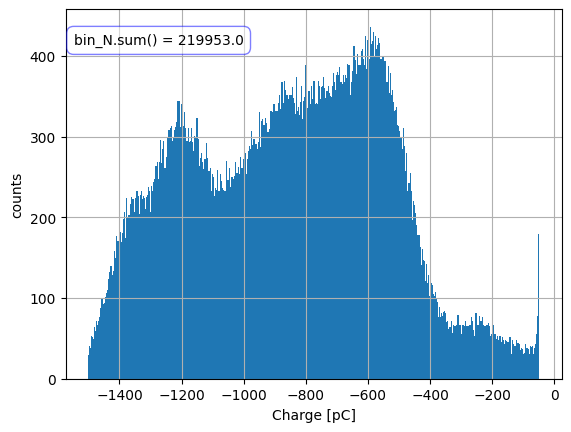

In [42]:
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))

plt.bar(centers_N, bin_N, width = 4)

#plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

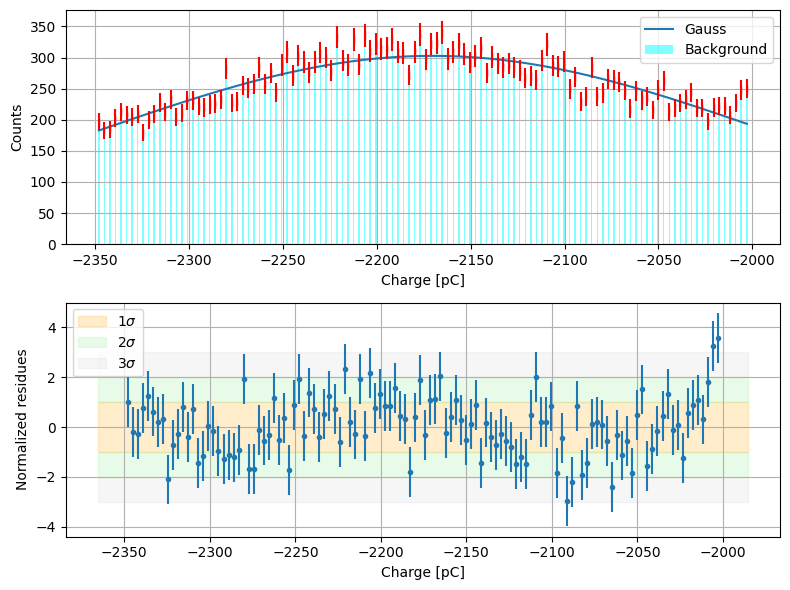

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 118
    # variables        = 3
    chi-square         = 169.070524
    reduced chi-square = 1.47017847
    Akaike info crit   = 48.4364937
    Bayesian info crit = 56.7485476
    R-squared          = 0.77686365
[[Variables]]
    g3_amplitude:  134276.589 +/- 2647.59242 (1.97%) (init = 56281.57)
    g3_center:    -2170.29884 +/- 2.32065826 (0.11%) (init = -2170.034)
    g3_sigma:      177.000254 +/- 4.55023034 (2.57%) (init = 116.525)
    g3_fwhm:       416.803737 +/- 10.7149734 (2.57%) == '2.3548200*g3_sigma'
    g3_height:     302.647089 +/- 3.03377617 (1.00%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma)  = +0.9363
    C(g3_amplitude, g3_center) = +0.1265
    C(g3_center, g3_sigma)     = +0.1204


In [18]:
#picco del fotoelettrico

sist_lims = lim_N
sist_bin = bin_N
sist_cntr = centers_N
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())


## peak 2

In [22]:
edge_N, bin_N = load_histo(PATH)
edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1

#if channel == 5:
    #rebin_fact = 2


bin_N = rebin(bin_N, rebin_fact)
tmp = []

for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)

In [27]:
lim_list = [[-1350, -1180],  #ch0
            [-1300, -1130],      #ch1      #rispetto a prima è cambiato un sacco :(
            [-5000, -4450],  #ch2
            [-3000, -2700],  #ch3
            [-2050, -1850],  #ch4
            [-3500, -3060],  #ch5
            [-2300, -2050],  #ch6
            [-3300, -2960],  #ch7
            [-2750, -2350],  #ch8
            [-550, -435],  #ch9
            [-490, -400],  #ch10
            [-900, -700],  #ch11
            [-800, -620],      #ch12
            [-1240, -1010],      #ch13
            [-1250, -1000],  #ch14
            [-1250, -1000]   #ch15
            ]


lim_N = lim_list[channel]
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

Text(0, 0.5, 'counts')

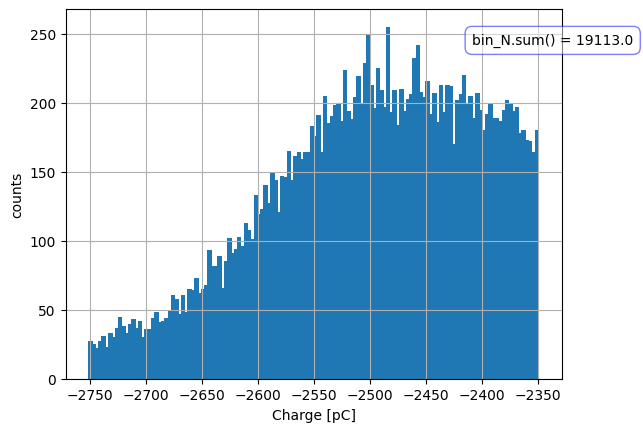

In [28]:
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))

plt.bar(centers_N, bin_N, width = 4)
#plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

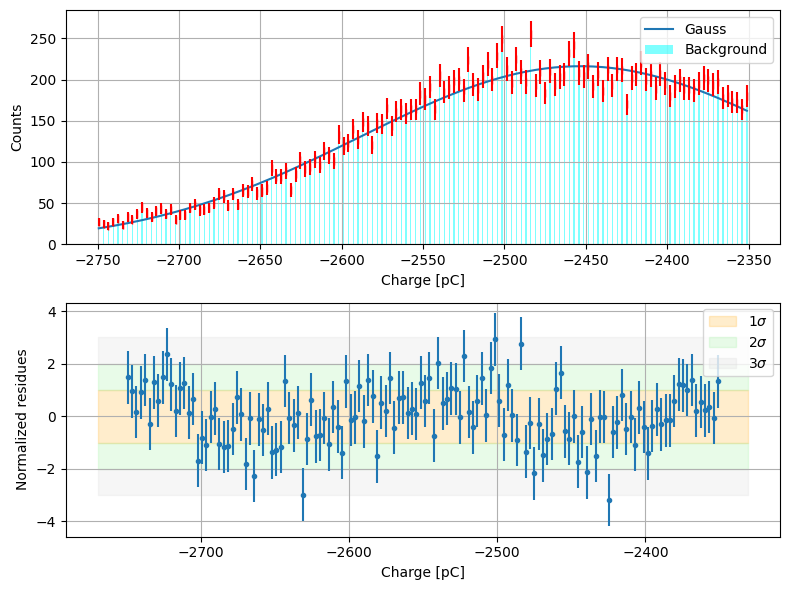

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 136
    # variables        = 3
    chi-square         = 162.685037
    reduced chi-square = 1.22319577
    Akaike info crit   = 30.3659177
    Bayesian info crit = 39.1038824
    R-squared          = 0.96317691
[[Variables]]
    g3_amplitude:  73005.9565 +/- 1057.26185 (1.45%) (init = 84544.05)
    g3_center:    -2453.22197 +/- 2.59452970 (0.11%) (init = -2469.146)
    g3_sigma:      134.686623 +/- 2.06469324 (1.53%) (init = 120.95)
    g3_fwhm:       317.162754 +/- 4.86198091 (1.53%) == '2.3548200*g3_sigma'
    g3_height:     216.243926 +/- 2.11539808 (0.98%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_center, g3_sigma)     = +0.8006
    C(g3_amplitude, g3_center) = +0.7927
    C(g3_amplitude, g3_sigma)  = +0.7861


In [29]:
#picco del fotoelettrico

sist_lims = lim_N
sist_bin = bin_N
sist_cntr = centers_N
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())

# Linearity

In [91]:
new_sigma_e= np.sqrt(sigma_e**2 + (0.01*peak_e)**2)
new_sigma_f= np.sqrt(sigma_e**2 + (0.01*peak_e)**2)
energy=np.array((511, 1274))

In [94]:
#faccio intercalibrazione rispetto al canale 2
lista=np.arange(0,16,step=1)
channel_ref=2
coeff_cal=peak_e/peak_e[channel_ref]
err_e=new_sigma_e/coeff_cal

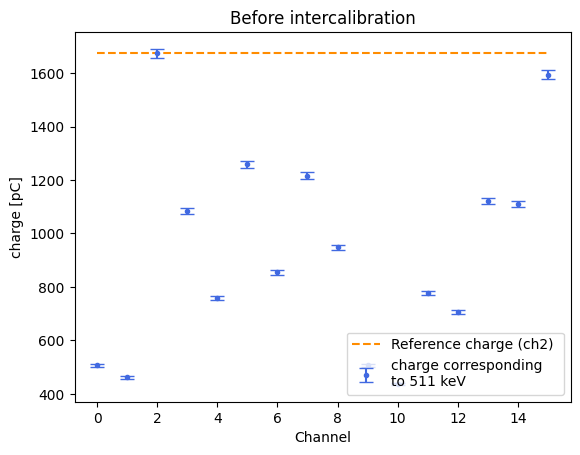

In [95]:
ref=peak_e[channel_ref]

plt.errorbar(lista, peak_e, yerr=new_sigma_e, ls='', capsize=5, marker='.', color='royalblue', label='charge corresponding\nto 511 keV')
plt.title("Before intercalibration")
plt.plot(lista, 0*np.array(lista) + ref, color='darkorange', ls='--', label='Reference charge (ch2) '.format(channel_ref))
plt.xlabel('Channel')
plt.ylabel("charge [pC]")
plt.legend(loc='lower right')

[-1.44051793  5.86447497  0.          5.25250137 -1.02522667  3.03184712
  1.30303538 -0.10390771 -0.37303776 -1.24878598 -0.160084    3.18229741
  3.24594322  1.57358107  1.42851281 -0.80625922]
[0.00420568 0.00409842 0.0041426  0.00406323 0.00417089 0.00411156
 0.00414028 0.00415852 0.00415441 0.00428346 0.00416583 0.00411595
 0.004142   0.00412752 0.004133   0.00417307]


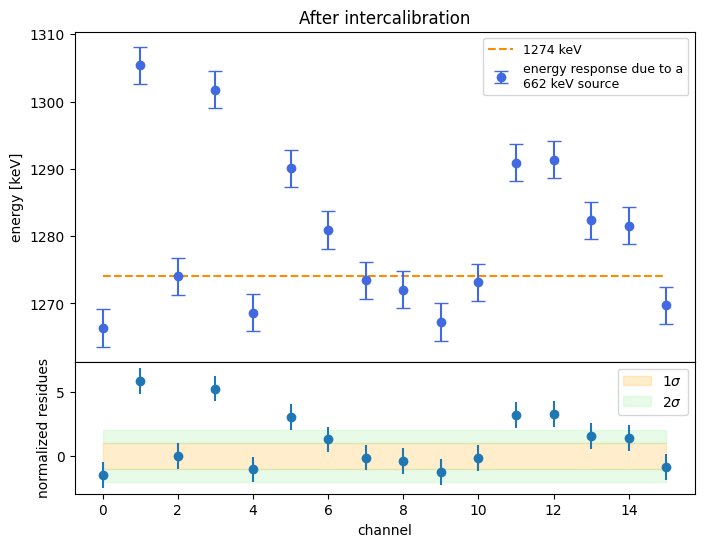

In [96]:
test_peak_centers=peak_f/coeff_cal

test_peak_errors=new_sigma_f/coeff_cal
ref=peak_f[channel_ref]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [5, 2]})

print( (test_peak_centers-ref)/test_peak_errors  )
ax1.plot(lista, 0*np.array(lista) + 1274, color='darkorange', ls='--', label='1274 keV '.format(channel_ref))
ax1.errorbar(lista, test_peak_centers*1274/ref, yerr=test_peak_errors*662/np.abs(ref), ls='', capsize=5, marker='o', color='royalblue', label='energy response due to a\n662 keV source')
ax1.legend(fontsize=9)
ax1.set_title("After intercalibration")
ax1.set_ylabel("energy [keV]")

xlim = ax1.get_xlim()
ax2.errorbar(lista,(np.array(test_peak_centers)-ref)/np.array(test_peak_errors), yerr=1, ls=' ', marker='o')
ax2.fill_between([0,15], [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between([0,15], [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between([0,15], [2, 2], [1, 1], color = "lightgreen", alpha = 0.2)
ax2.set_xlabel("channel")
ax2.set_ylabel("normalized residues")
ax2.legend()
plt.subplots_adjust(hspace=0)

print(test_peak_errors/test_peak_centers)

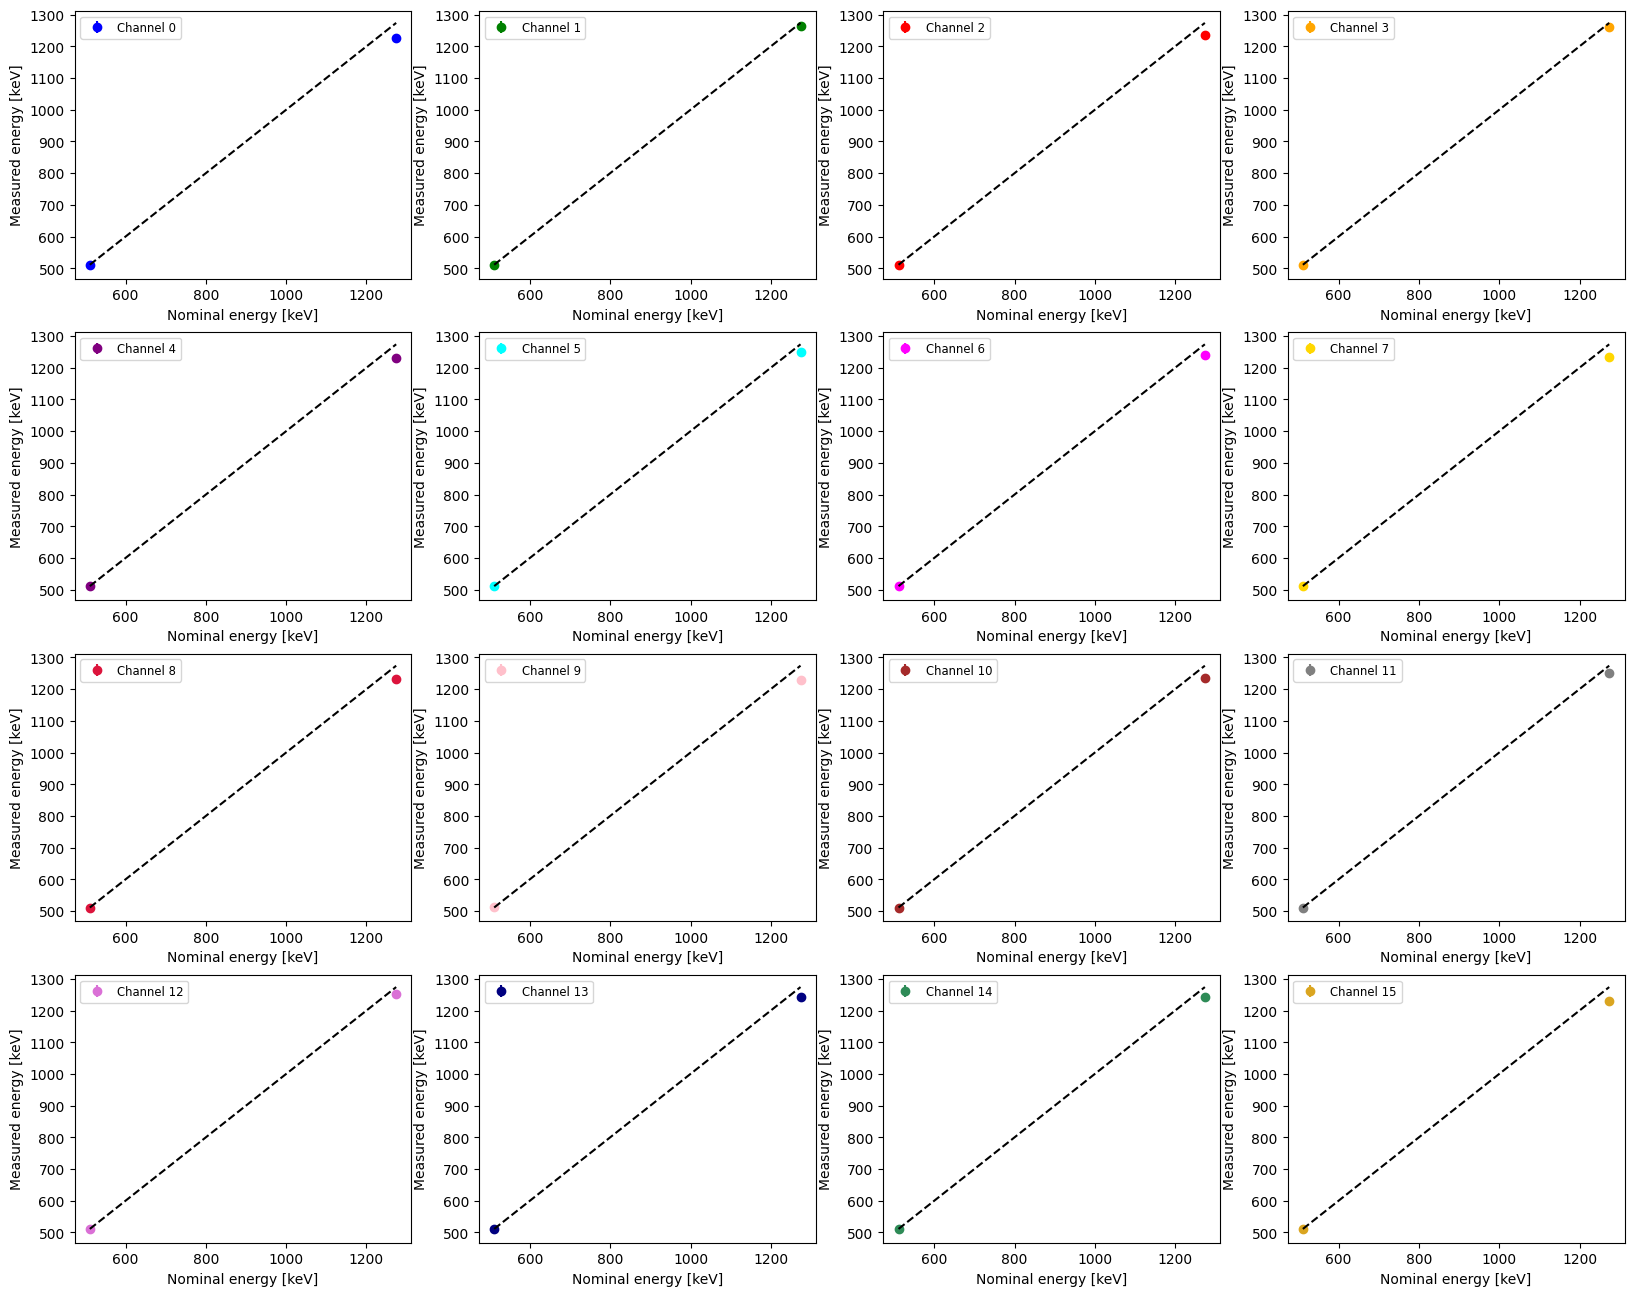

In [98]:

ch=np.arange(0,16,step=1)
colors = ['blue', 'green', 'red', 'orange', 'purple', 'cyan', 'magenta', 'gold', 'crimson', 'pink', 'brown', 'gray', 'orchid', 'navy', 
          'seagreen', 'goldenrod']

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 16))#, sharex=True)
ref_g=peak_e[channel_ref]
energia=511/ref_g
energy_g=peak_e/coeff_cal*energia
sigma_g=new_sigma_e/coeff_cal*energia
ref_f=peak_f[channel_ref]
energy_f=test_peak_centers*energia
sigma_f=test_peak_errors*energia
# Iterate over each element in channels
for j, color in enumerate(colors):
    # Calculate subplot row and column
    row = j // 4
    col = j % 4
    
    # Plot error bars on the corresponding subplot with different color
    axes[row, col].errorbar(energy, np.array([energy_g[j], energy_f[j]]), yerr=np.array([sigma_g[j], sigma_f[j]]), 
                            ls='', marker='o', color=color, label='Channel {}'.format(j))

   

    axes[row, col].errorbar(energy, energy, ls='--', color='black')
    
    axes[row, col].set_xlabel("Nominal energy [keV]")
    axes[row, col].set_ylabel("Measured energy [keV]")
    axes[row, col].legend(fontsize='small')  # Add legend for each subplot

# Linearity for each channel

In [31]:
peak_e=np.abs(np.array([-506.734, -461.730, -1673.738, -1085.422, -758.996, -1258.207, -854.866, -1216.707, -948.590, -506.800,
       -437.591, -776.004, -705.231, -1121.940, -1111.193, -1593.873]))
sigma_e=np.array([0.715, 0.789, 0.664, 0.844, 0.620, 1.360, 0.91, 1.116, 0.613, 1.236, 
         0.469, 0.955, 1.196, 0.961, 1.043, 1.558])
peak_f=np.abs(np.array([-1216.816, -1142.936, -4043.482, -2679.389, -1825.805, -3077.995, -2076.421, -2938.099, -2288.095, -1217.833,
       -1056.445, -1899.582, -1726.943, -2728.146, -2700.407, -3837.629] ))
sigma_f=np.array([1.615, 1.780, 2.493, 3.325, 1.683, 3.790, 2.369, 3.218, 1.281, 1.511,
        0.967, 2.157, 2.608, 2.609, 2.604, 4.468])

In [32]:
def retta(x, a, b):
    return(a*x + b)

In [33]:
channel_ref=3

ref_g=peak_e[channel_ref]
energia=511/ref_g

coeff_cal=peak_f/peak_f[channel_ref]
print(coeff_cal)

[0.45413936 0.42656591 1.50910599 1.         0.68142588 1.1487675
 0.77496063 1.0965556  0.85396148 0.45451892 0.39428579 0.70896089
 0.64452866 1.01819706 1.00784433 1.43227766]


In [162]:
channel_ref=3

ref_g=peak_f[channel_ref]
energia=1274/ref_g

coeff_cal=peak_f/peak_f[channel_ref]
print(coeff_cal)

[0.45413936 0.42656591 1.50910599 1.         0.68142588 1.1487675
 0.77496063 1.0965556  0.85396148 0.45451892 0.39428579 0.70896089
 0.64452866 1.01819706 1.00784433 1.43227766]


### ch 0

In [164]:
ch_0=np.abs([-506.734, -1216.816, -359.830, -1092.329, -1237.615]/coeff_cal[0]*energia)
en_ch_0=np.array([511, 1274, 356, 1173.2, 1332.5])
sigma_ch_0=[0.715, 1.615, 0.792, 0.888, 0.932]/coeff_cal[0]*energia  #0.792 è da sistemare, solo errore del fit
ch=0
par0, cov0= curve_fit(retta, en_ch_0, ch_0, sigma=sigma_ch_0)
print(par0, np.sqrt(cov0[0][0]), np.sqrt(cov0[1][1]))

[ 0.93236779 44.84244422] 0.011754894249708017 10.557468602919378


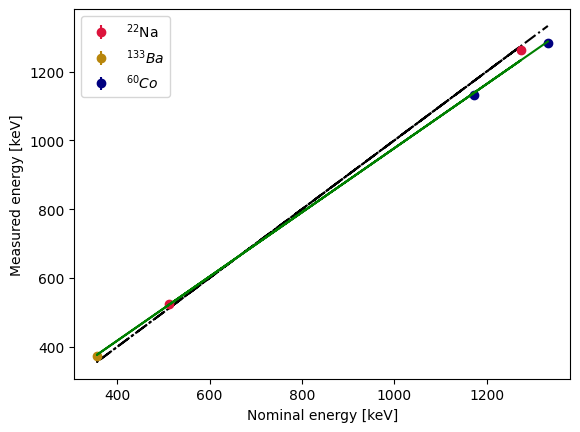

In [165]:
en_ch_=en_ch_0
ch_=ch_0
sigma_ch_=sigma_ch_0
par=par0
plt.errorbar(en_ch_[0:2], ch_[0:2], yerr=sigma_ch_[0:2], ls='', marker='o', color='crimson', label='$^{22}$Na')
plt.errorbar(en_ch_[2], ch_[2], yerr=sigma_ch_[2], ls='', marker='o', color='darkgoldenrod', label='$^{133}Ba$')
plt.errorbar(en_ch_[3:], ch_[3:], yerr=sigma_ch_[3:], ls='', marker='o', color='navy', label='$^{60}Co$')
plt.errorbar(en_ch_, retta(en_ch_, par[0], par[1]), color='green')
plt.plot(en_ch_, en_ch_, ls='-.', color='black')
plt.xlabel("Nominal energy [keV]")
plt.ylabel("Measured energy [keV]")
plt.legend()  # Add legend for each subplot

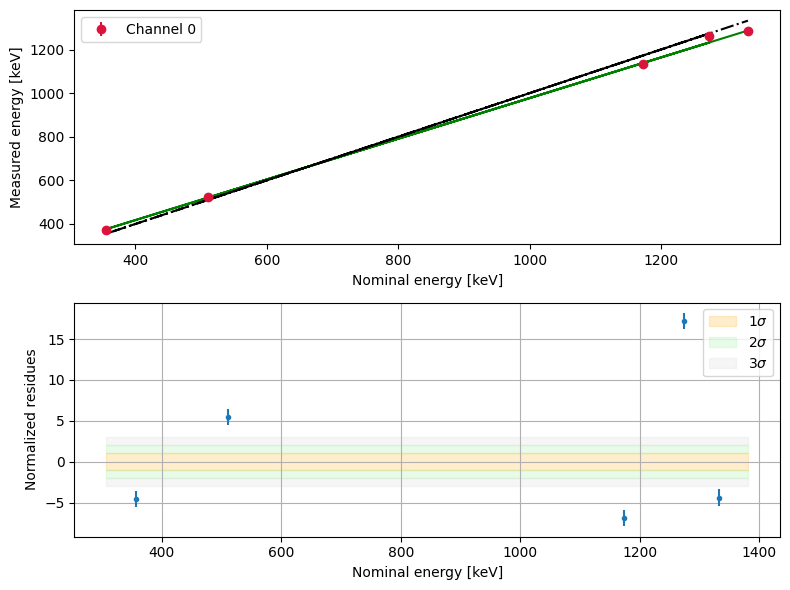

[ 4.02460925 28.73616255 -3.74676077 -6.33090587 -4.24602087]


In [166]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.errorbar(en_ch_, ch_, yerr=sigma_ch_, ls='', marker='o', color='crimson', label='Channel {}'.format(ch))
ax1.plot(en_ch_, retta(en_ch_,par[0], par[1]), color='green')
ax1.plot(en_ch_, en_ch_, ls='-.', color='black')
ax1.set_xlabel("Nominal energy [keV]")
ax1.set_ylabel("Measured energy [keV]")
ax1.legend()  # Add legend for each subplot

residue= ch_- retta(en_ch_, par[0], par[1])
norm_res = residue / sigma_ch_

ax2.errorbar(en_ch_, norm_res, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Nominal energy [keV]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()
print(residue)

### ch 1

In [167]:
ch=1
ch_1=np.abs([-461.730, -1142.936, -78.992, -315.134, -1042.832, -1186.104])/coeff_cal[ch]*energia
en_ch_1=np.abs([511, 1274, 81,  (276.4*0.088+302.85*0.666)/(0.088+0.666) , 1173.2, 1332.5])
sigma_ch_1=np.sqrt(np.array([0.789, 1.780, 0.5, 1.049, 0.778, 0.782])**2+(ch_1*0.01)**2)/coeff_cal[ch]*energia
par1, cov1= curve_fit(retta, en_ch_1, ch_1, sigma=sigma_ch_1)
print(par1, np.sqrt(cov1[0][0]), np.sqrt(cov1[1][1]))

[0.99613923 8.80806147] 0.03207769884089176 7.020909769979183


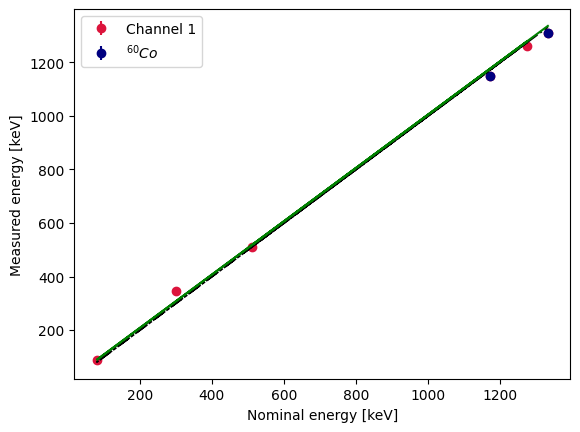

In [168]:
plt.errorbar(en_ch_1, ch_1, yerr=sigma_ch_1, ls='', marker='o', color='crimson', label='Channel {}'.format(ch))
plt.errorbar(en_ch_1[4:], ch_1[4:], yerr=sigma_ch_1[4:], ls='', marker='o', color='navy', label='$^{60}Co$')
plt.errorbar(en_ch_1, en_ch_1, ls='-.', color='black')
plt.errorbar(en_ch_1, retta(en_ch_1, par1[0], par1[1]), color='green')
plt.xlabel("Nominal energy [keV]")
plt.ylabel("Measured energy [keV]")
plt.legend()  # Add legend for each subplot

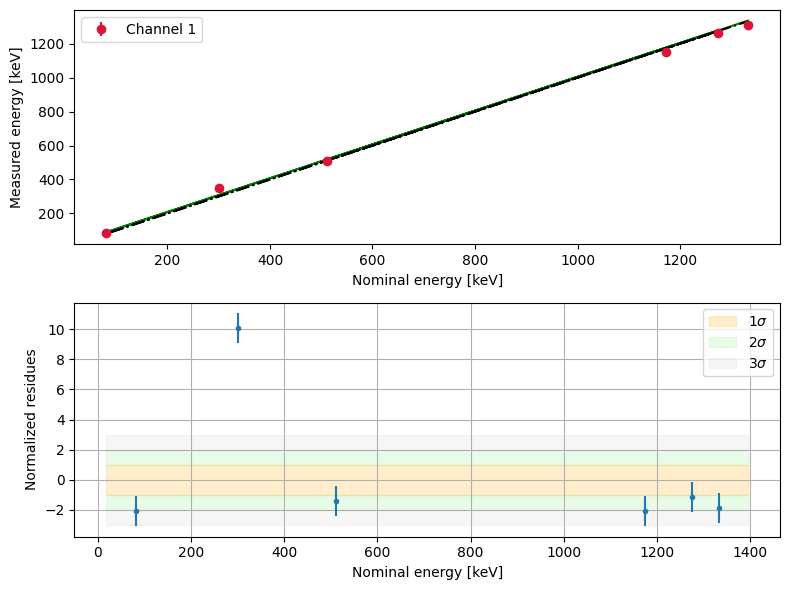

[ -8.24129621 -16.47426893  -2.31486072  40.38771649 -26.54442765
 -27.10552739]


In [169]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.errorbar(en_ch_1, ch_1, yerr=sigma_ch_1, ls='', marker='o', color='crimson', label='Channel {}'.format(ch))
ax1.plot(en_ch_1, retta(en_ch_1,par1[0], par1[1]), color='green')
ax1.plot(en_ch_1, en_ch_1, ls='-.', color='black')
ax1.set_xlabel("Nominal energy [keV]")
ax1.set_ylabel("Measured energy [keV]")
ax1.legend()  # Add legend for each subplot

residue= ch_1 - retta(en_ch_1, par1[0], par1[1])
norm_res = residue / sigma_ch_1

ax2.errorbar(en_ch_1, norm_res, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Nominal energy [keV]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()
print(residue)

### ch2

In [96]:
ch=2 
ch_2=np.abs([-1673.738, -4043.482, -122.249, -309.287, -1064.259,  -1245.953, -4059.473, -4612.032])/coeff_cal[ch]*energia
en_ch_2=np.array([511, 1274, 30.85, 81, (276.4*0.088+302.85*0.666)/(0.088+0.666), (356.02*0.738+383.9*0.317)/(0.317+0.738), 1173.2, 1332.5])
sigma_ch_2=np.sqrt(np.array([ 0.664, 2.493, 0.141, 0.226, 2.641, 0.493, 2.224, 2.424])**2 + (ch_2*0.01)**2)/coeff_cal[ch]*energia
par, cov= curve_fit(retta, en_ch_2, ch_2, sigma=sigma_ch_2)
print(par, np.sqrt(cov[0][0]), np.sqrt(cov[1][1]))

[1.05633762 6.77756175] 0.01950714544171238 1.8041479121019686


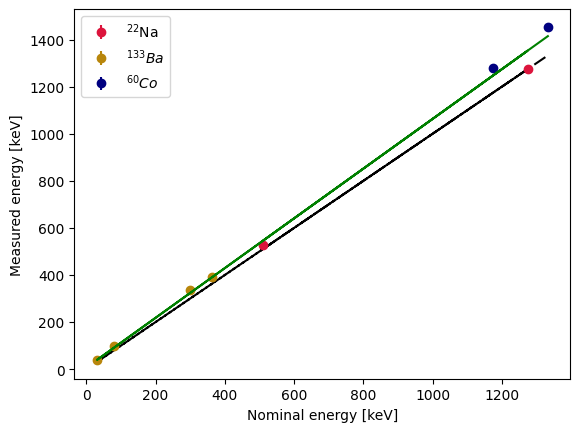

In [126]:
en_ch_=en_ch_2
ch_=ch_2
sigma_ch_=sigma_ch_2
plt.errorbar(en_ch_[0:2], ch_[0:2], yerr=sigma_ch_[0:2], ls='', marker='o', color='crimson', label='$^{22}$Na')
plt.errorbar(en_ch_[2:6], ch_[2:6], yerr=sigma_ch_[2:6], ls='', marker='o', color='darkgoldenrod', label='$^{133}Ba$')
plt.errorbar(en_ch_[6:], ch_[6:], yerr=sigma_ch_[6:], ls='', marker='o', color='navy', label='$^{60}Co$')
plt.errorbar(en_ch_2, retta(en_ch_2, par[0], par[1]), color='green')
plt.plot(en_ch_2, en_ch_2, ls='-.', color='black')
plt.xlabel("Nominal energy [keV]")
plt.ylabel("Measured energy [keV]")
plt.legend()  # Add legend for each subplot

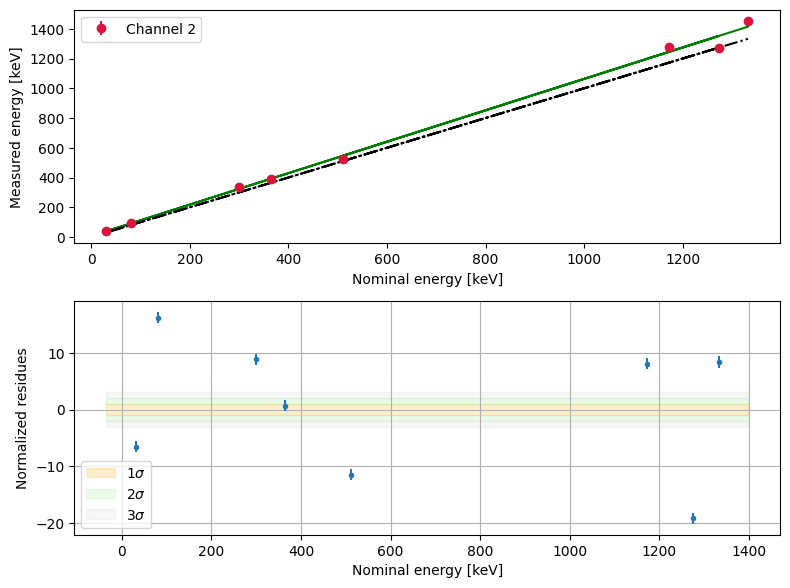

[-19.21312404 -78.55169233  -0.84797648   5.10768541  11.89288686
   0.86456586  32.96550394  38.78843521]


In [125]:


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.errorbar(en_ch_2, ch_2, yerr=sigma_ch_2, ls='', marker='o', color='crimson', label='Channel {}'.format(ch))
ax1.plot(en_ch_2, retta(en_ch_2,par[0], par[1]), color='green')
ax1.plot(en_ch_2, en_ch_2, ls='-.', color='black')
ax1.set_xlabel("Nominal energy [keV]")
ax1.set_ylabel("Measured energy [keV]")
ax1.legend()  # Add legend for each subplot

residue= ch_2 - retta(en_ch_2, par[0], par[1])
norm_res = residue / sigma_ch_2

ax2.errorbar(en_ch_2, norm_res, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Nominal energy [keV]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()
print(residue)

In [42]:
#kolmogorov smirnov
print(' ')
print('Test del K-S per il set 2')
t2=[]
valori=residue
N=len(valori)
media=np.mean(valori)
sigma=np.std(valori)
for j in range(0,N):
  t2.append((valori[j] - media)/sigma)
t2=sorted(t2)
print(t2)

 
Test del K-S per il set 2
[-2.103272578868079, -0.18009311607673537, 0.26064620779062025, 0.5339047580594779, 0.5412626582115474, 0.9475520708831686]


In [47]:
diff=[]
cumulata=[0.167, 0.167*2, 0.167*3, 0.167*4, 0.167*5, 1]
#devi metterci i valori che ottieni facendo 1/N e sommandoli
#in t2 devi mettere i valori di t ottenuti con distcalc
#devi mettere 1-alpha di distcalc
t=[1-0.98228, 1-0.57146, 1-0.39718, 1-0.2967, 1-0.29416, 1-0.17168]
for i in range(0,N):
  diff.append(cumulata[i]-t[i])
print(f'differenza={diff}')
#cerca il valore nella tabella
print(min(diff))
print(max(diff))
#la significatività è superiore al 20%

differenza=[0.14928000000000005, -0.09454000000000001, -0.10182000000000002, -0.0353, 0.12916000000000005, 0.17168000000000005]
-0.10182000000000002
0.17168000000000005


### ch 3

In [170]:
ch=3
ch_3=np.abs([peak_e[ch], peak_f[ch], -75.484, -178.424, -753.299, -703.840, -2481.343, -2818.145])/coeff_cal[ch]*energia
en_ch_3=np.array([511, 1274, 30.85, 81, (356.02*0.738+383.9*0.317)/(0.317+0.738), (276.4*0.088+302.85*0.666)/(0.088+0.666), 1173.2, 1332.5])
sigma_ch_3=np.sqrt(np.array([sigma_e[ch], sigma_f[ch], 0.708, 0.534, 0.969, 21.606, 1.929, 1.906])**2+(ch_3*0.01)**2)/coeff_cal[ch]*energia
par3, cov3= curve_fit(retta, en_ch_3, ch_3, sigma=sigma_ch_3)
print(par3, np.sqrt(cov3[0][0]), np.sqrt(cov3[1][1]))

[0.98445574 4.68768055] 0.0062324243909361405 0.9007602101051054


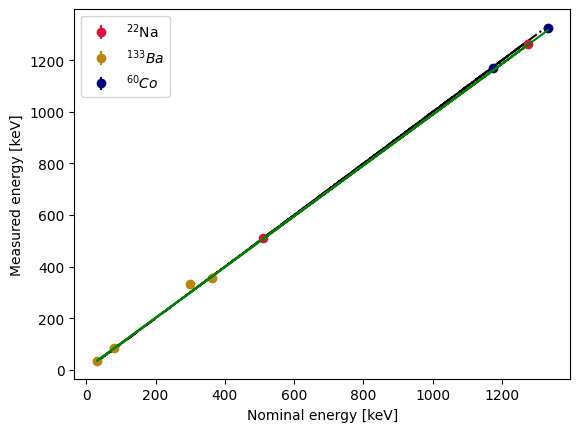

In [171]:
plt.errorbar(en_ch_3[0:2], ch_3[0:2], yerr=sigma_ch_3[0:2], ls='', marker='o', color='crimson', label='$^{22}$Na')
plt.errorbar(en_ch_3[2:6], ch_3[2:6], yerr=sigma_ch_3[2:6], ls='', marker='o', color='darkgoldenrod', label='$^{133}Ba$')
plt.errorbar(en_ch_3[6:], ch_3[6:], yerr=sigma_ch_3[6:], ls='', marker='o', color='navy', label='$^{60}Co$')
plt.errorbar(en_ch_3, retta(en_ch_3, par3[0], par3[1]), color='green')
plt.plot(en_ch_3, en_ch_3, ls='-.', color='black')
plt.xlabel("Nominal energy [keV]")
plt.ylabel("Measured energy [keV]")
plt.legend()  # Add legend for each subplot

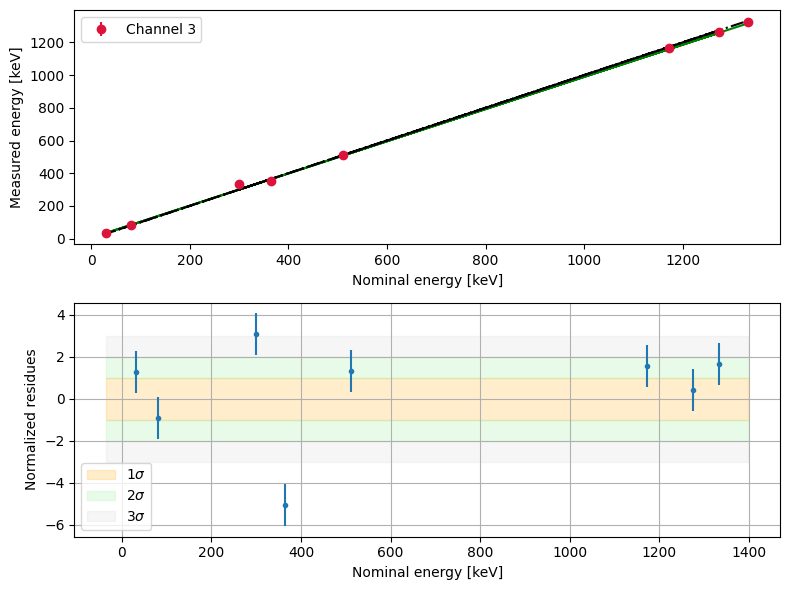

[ 3.2554352   2.53087608  0.47856719 -0.42931796 -8.77901489 31.56597286
  8.52700108 10.26440796]


In [172]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.errorbar(en_ch_3, ch_3, yerr=sigma_ch_3, ls='', marker='o', color='crimson', label='Channel {}'.format(ch))
ax1.plot(en_ch_3, retta(en_ch_3,par3[0], par3[1]), color='green')
ax1.plot(en_ch_3, en_ch_3, ls='-.', color='black')
ax1.set_xlabel("Nominal energy [keV]")
ax1.set_ylabel("Measured energy [keV]")
ax1.legend()  # Add legend for each subplot

residue= ch_3 - retta(en_ch_3, par3[0], par3[1])
norm_res = residue / sigma_ch_3

ax2.errorbar(en_ch_3, norm_res, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Nominal energy [keV]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()
print(residue)

In [ ]:
#kolmogorov smirnov
print(' ')
print('Test del K-S per il set 2')
t2=[]
valori=residue
N=len(valori)
media=np.mean(valori)
sigma=np.std(valori)
for j in range(0,N):
  t2.append((valori[j] - media)/sigma)
t2=sorted(t2)
print(t2)

In [ ]:
diff=[]
cumulata=[0.167, 0.167*2, 0.167*3, 0.167*4, 0.167*5, 1]
#devi metterci i valori che ottieni facendo 1/N e sommandoli
#in t2 devi mettere i valori di t ottenuti con distcalc
#devi mettere 1-alpha di distcalc
t=[1-0.98228, 1-0.57146, 1-0.39718, 1-0.2967, 1-0.29416, 1-0.17168]
for i in range(0,N):
  diff.append(cumulata[i]-t[i])
print(f'differenza={diff}')
#cerca il valore nella tabella
print(min(diff))
print(max(diff))
#la significatività è superiore al 20%

### ch 4

In [198]:
ch=4
ch_4=np.abs([peak_e[ch], peak_f[ch], -53.037, -125.63, -516.241, -462.6, -1682.396, -1912.819])/coeff_cal[ch]*energia  #l'ultimo è con molta fantasia, è una mini gobba
en_ch_4=np.abs([511, 1274, 30.85, 81, (356.02*0.738+383.9*0.317)/(0.317+0.738), (276.4*0.088+302.85*0.666)/(0.088+0.666), 1173.2, 1332.5])
#en_ch_3=np.array([511, 1274, 30.85, 81, (356.02*0.738+383.9*0.317)/(0.317+0.738), (276.4*0.088+302.85*0.666)/(0.088+0.666)])
sigma_ch_4=np.sqrt(np.array([sigma_e[ch], sigma_f[ch], 0.638, 0.307, 0.510, 6.676, 1.263,1.335])**2+(ch_4*0.01)**2)/coeff_cal[ch]*energia
par4, cov4= curve_fit(retta, en_ch_4, ch_4, sigma=sigma_ch_4)
print(par4, np.sqrt(cov4[0][0]), np.sqrt(cov4[1][1]))

[0.98836694 6.36412733] 0.008489743019810791 1.1752253613312993


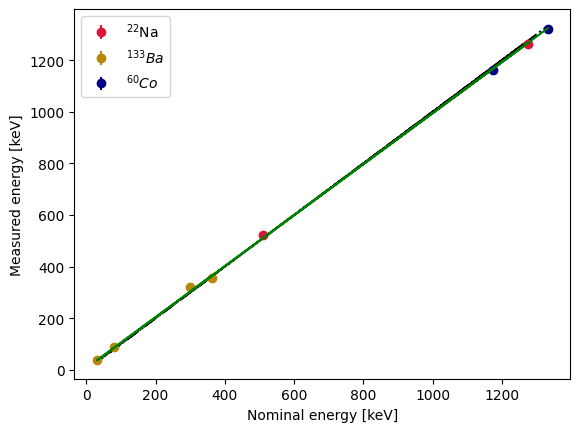

In [199]:
plt.errorbar(en_ch_4[0:2], ch_4[0:2], yerr=sigma_ch_4[0:2], ls='', marker='o', color='crimson', label='$^{22}$Na')
plt.errorbar(en_ch_4[2:6], ch_4[2:6], yerr=sigma_ch_4[2:6], ls='', marker='o', color='darkgoldenrod', label='$^{133}Ba$')
plt.errorbar(en_ch_4[6:], ch_4[6:], yerr=sigma_ch_4[6:], ls='', marker='o', color='navy', label='$^{60}Co$')
plt.errorbar(en_ch_4, retta(en_ch_4, par4[0], par4[1]), color='green')
plt.plot(en_ch_4, en_ch_4, ls='-.', color='black')
plt.xlabel("Nominal energy [keV]")
plt.ylabel("Measured energy [keV]")
plt.legend()  # Add legend for each subplot

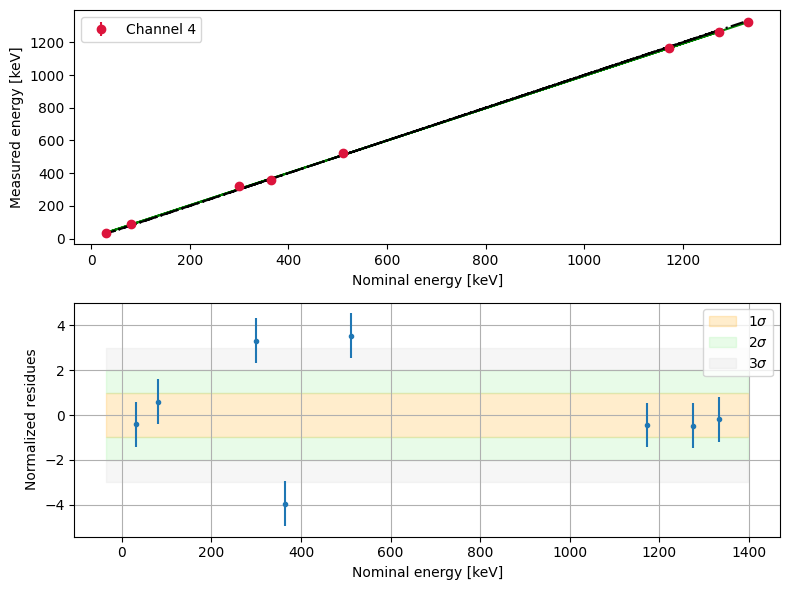

[12.95677738 -4.12843239 -0.21295722  0.37361257 -9.86085051 16.96188886
 -3.57969182 -1.83152224]


In [200]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.errorbar(en_ch_4, ch_4, yerr=sigma_ch_4, ls='', marker='o', color='crimson', label='Channel {}'.format(ch))
ax1.plot(en_ch_4, retta(en_ch_4,par4[0], par4[1]), color='green')
ax1.plot(en_ch_4, en_ch_4, ls='-.', color='black')
ax1.set_xlabel("Nominal energy [keV]")
ax1.set_ylabel("Measured energy [keV]")
ax1.legend()  # Add legend for each subplot

residue= ch_4- retta(en_ch_4, par4[0], par4[1])
norm_res = residue / sigma_ch_4

ax2.errorbar(en_ch_4, norm_res, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Nominal energy [keV]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()
print(residue)

In [ ]:
#kolmogorov smirnov
print(' ')
print('Test del K-S per il set 2')
t2=[]
valori=residue
N=len(valori)
media=np.mean(valori)
sigma=np.std(valori)
for j in range(0,N):
  t2.append((valori[j] - media)/sigma)
t2=sorted(t2)
print(t2)

In [ ]:
diff=[]
cumulata=[0.167, 0.167*2, 0.167*3, 0.167*4, 0.167*5, 1]
#devi metterci i valori che ottieni facendo 1/N e sommandoli
#in t2 devi mettere i valori di t ottenuti con distcalc
#devi mettere 1-alpha di distcalc
t=[1-0.98228, 1-0.57146, 1-0.39718, 1-0.2967, 1-0.29416, 1-0.17168]
for i in range(0,N):
  diff.append(cumulata[i]-t[i])
print(f'differenza={diff}')
#cerca il valore nella tabella
print(min(diff))
print(max(diff))
#la significatività è superiore al 20%

### ch 5

In [229]:
ch=5
ch_5=np.abs([peak_e[ch], peak_f[ch], -202.278, -858.808,  -743.503, -2825.912, -3211.982])/coeff_cal[ch]*energia
en_ch_5=np.array([511, 1274, 81, (356.02*0.738+383.9*0.317)/(0.317+0.738), (276.4*0.088+302.85*0.666)/(0.088+0.666), 1173.2, 1332.5])
#en_ch_3=np.array([511, 1274, 30.85, 81, (356.02*0.738+383.9*0.317)/(0.317+0.738), (276.4*0.088+302.85*0.666)/(0.088+0.666)])
sigma_ch_5=[sigma_e[ch], sigma_f[ch], 1.504, 1.944, 16.012, 1.824, 1.873]/coeff_cal[ch]*energia
par5, cov5= curve_fit(retta, en_ch_5, ch_5, sigma=sigma_ch_5)
print(par5, np.sqrt(cov5[0][0]), np.sqrt(cov5[1][1]))

[0.98563167 4.05614087] 0.005794738555574625 4.621014420774036


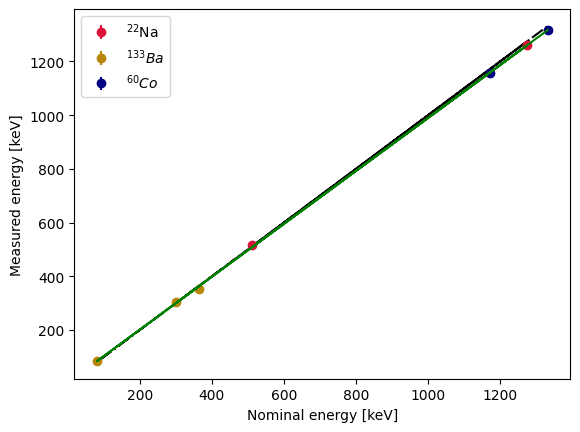

In [232]:
plt.errorbar(en_ch_5[0:2], ch_5[0:2], yerr=sigma_ch_5[0:2], ls='', marker='o', color='crimson', label='$^{22}$Na')

plt.errorbar(en_ch_5[2:5], ch_5[2:5], yerr=sigma_ch_5[2:5], ls='', marker='o', color='darkgoldenrod', label='$^{133}Ba$')
plt.errorbar(en_ch_5[5:], ch_5[5:], yerr=sigma_ch_5[5:], ls='', marker='o', color='navy', label='$^{60}Co$')
plt.errorbar(en_ch_5, retta(en_ch_5, par5[0], par5[1]), color='green')
plt.plot(en_ch_5, en_ch_5, ls='-.', color='black')
plt.xlabel("Nominal energy [keV]")
plt.ylabel("Measured energy [keV]")
plt.legend()  # Add legend for each subplot

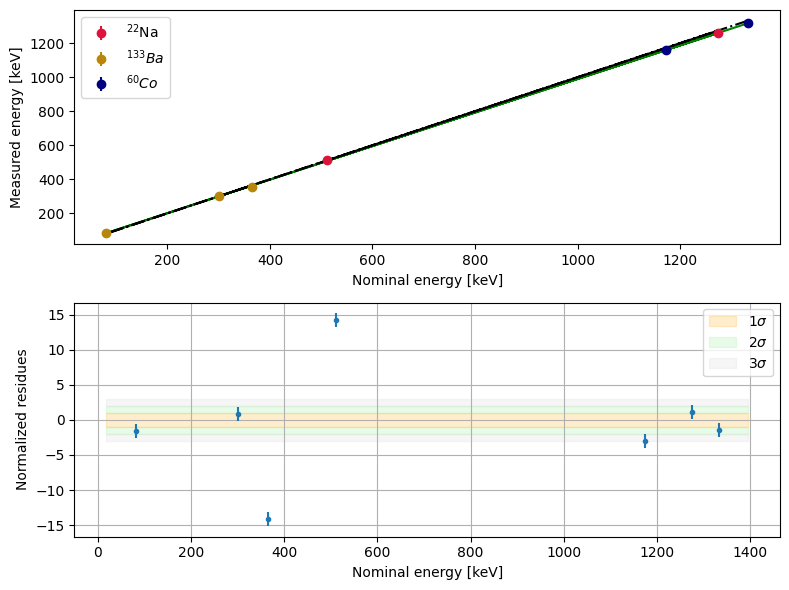

[  7.92089766   1.66428705  -0.99531026 -11.26331746   5.18824481
  -2.29198025  -1.08499356]


In [235]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.errorbar(en_ch_5[0:2], ch_5[0:2], yerr=sigma_ch_5[0:2], ls='', marker='o', color='crimson', label='$^{22}$Na')

ax1.errorbar(en_ch_5[2:5], ch_5[2:5], yerr=sigma_ch_5[2:5], ls='', marker='o', color='darkgoldenrod', label='$^{133}Ba$')
ax1.errorbar(en_ch_5[5:], ch_5[5:], yerr=sigma_ch_5[5:], ls='', marker='o', color='navy', label='$^{60}Co$')
ax1.plot(en_ch_5, retta(en_ch_5,par5[0], par5[1]), color='green')
ax1.plot(en_ch_5, en_ch_5, ls='-.', color='black')
ax1.set_xlabel("Nominal energy [keV]")
ax1.set_ylabel("Measured energy [keV]")
ax1.legend()  # Add legend for each subplot

residue= ch_5- retta(en_ch_5, par5[0], par5[1])
norm_res = residue / sigma_ch_5

ax2.errorbar(en_ch_5, norm_res, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Nominal energy [keV]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()
print(residue)

In [ ]:
#kolmogorov smirnov
print(' ')
print('Test del K-S per il set 2')
t2=[]
valori=residue
N=len(valori)
media=np.mean(valori)
sigma=np.std(valori)
for j in range(0,N):
  t2.append((valori[j] - media)/sigma)
t2=sorted(t2)
print(t2)

In [ ]:
diff=[]
cumulata=[0.167, 0.167*2, 0.167*3, 0.167*4, 0.167*5, 1]
#devi metterci i valori che ottieni facendo 1/N e sommandoli
#in t2 devi mettere i valori di t ottenuti con distcalc
#devi mettere 1-alpha di distcalc
t=[1-0.98228, 1-0.57146, 1-0.39718, 1-0.2967, 1-0.29416, 1-0.17168]
for i in range(0,N):
  diff.append(cumulata[i]-t[i])
print(f'differenza={diff}')
#cerca il valore nella tabella
print(min(diff))
print(max(diff))
#la significatività è superiore al 20%

### ch 6

In [264]:
ch=6
ch_6=np.abs([peak_e[ch], peak_f[ch], -58.804,  -138.291, -534.679, -589.225, -1861.951, -2116.112])/coeff_cal[ch]*energia
en_ch_6=np.array([511, 1274, 30.85, 81,(276.4*0.088+302.85*0.666)/(0.088+0.666), (356.02*0.738+383.9*0.317)/(0.317+0.738), 1173.2, 1332.5])
#en_ch_3=np.array([511, 1274, 30.85, 81, (356.02*0.738+383.9*0.317)/(0.317+0.738), (276.4*0.088+302.85*0.666)/(0.088+0.666)])
sigma_ch_6=[sigma_e[ch], sigma_f[ch], 2.629, 0.771, 29.596, 0.957, 1.456, 2.037]/coeff_cal[ch]*energia
par6, cov6= curve_fit(retta, en_ch_6, ch_6, sigma=sigma_ch_6)
print(par6, np.sqrt(cov6[0][0]), np.sqrt(cov6[1][1]))

[0.96698875 9.94961148] 0.01033263159617474 6.25310423064423


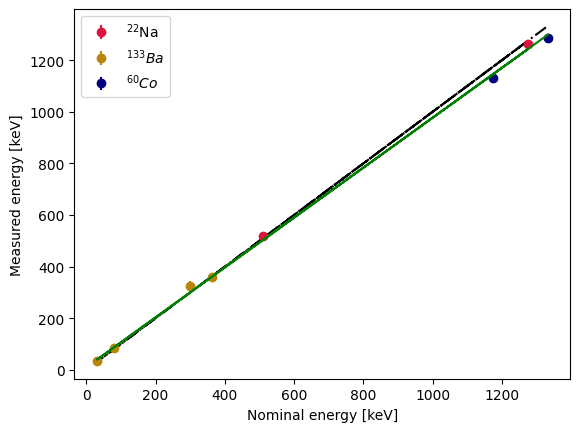

In [265]:
plt.errorbar(en_ch_6[0:2], ch_6[0:2], yerr=sigma_ch_6[0:2], ls='', marker='o', color='crimson', label='$^{22}$Na')

plt.errorbar(en_ch_6[2:6], ch_6[2:6], yerr=sigma_ch_6[2:6], ls='', marker='o', color='darkgoldenrod', label='$^{133}Ba$')
plt.errorbar(en_ch_6[6:], ch_6[6:], yerr=sigma_ch_6[6:], ls='', marker='o', color='navy', label='$^{60}Co$')
plt.errorbar(en_ch_6, retta(en_ch_6, par6[0], par6[1]), color='green')
plt.plot(en_ch_6, en_ch_6, ls='-.', color='black')
plt.xlabel("Nominal energy [keV]")
plt.ylabel("Measured energy [keV]")
plt.legend()  # Add legend for each subplot

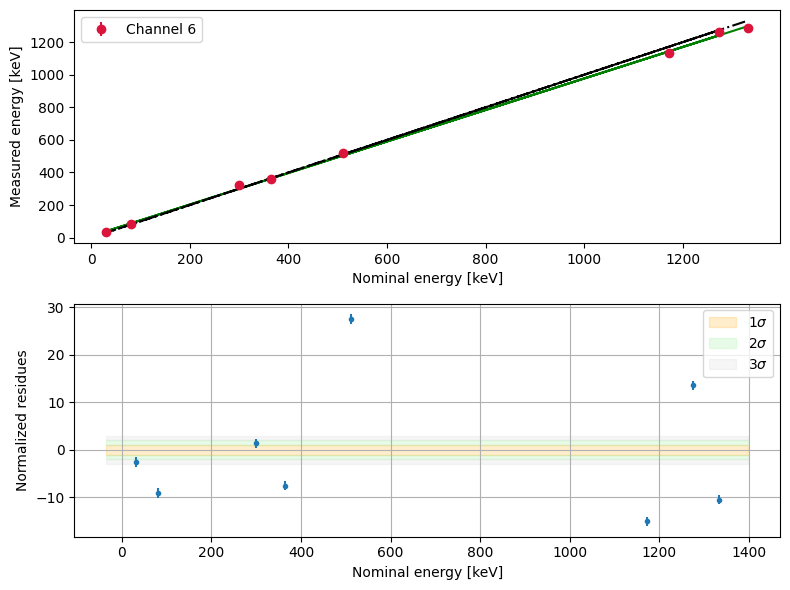

[ 15.24587485  19.52189463  -4.05808415  -4.26462262  24.99770954
  -4.36643312 -13.29507114 -12.93486702]


In [266]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.errorbar(en_ch_6, ch_6, yerr=sigma_ch_6, ls='', marker='o', color='crimson', label='Channel {}'.format(ch))
ax1.plot(en_ch_6, retta(en_ch_6,par6[0], par6[1]), color='green')
ax1.plot(en_ch_6, en_ch_6, ls='-.', color='black')
ax1.set_xlabel("Nominal energy [keV]")
ax1.set_ylabel("Measured energy [keV]")
ax1.legend()  # Add legend for each subplot

residue= ch_6- retta(en_ch_6, par6[0], par6[1])
norm_res = residue / sigma_ch_6

ax2.errorbar(en_ch_6, norm_res, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Nominal energy [keV]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()
print(residue)

In [ ]:
#kolmogorov smirnov
print(' ')
print('Test del K-S per il set 2')
t2=[]
valori=residue
N=len(valori)
media=np.mean(valori)
sigma=np.std(valori)
for j in range(0,N):
  t2.append((valori[j] - media)/sigma)
t2=sorted(t2)
print(t2)

In [ ]:
diff=[]
cumulata=[0.167, 0.167*2, 0.167*3, 0.167*4, 0.167*5, 1]
#devi metterci i valori che ottieni facendo 1/N e sommandoli
#in t2 devi mettere i valori di t ottenuti con distcalc
#devi mettere 1-alpha di distcalc
t=[1-0.98228, 1-0.57146, 1-0.39718, 1-0.2967, 1-0.29416, 1-0.17168]
for i in range(0,N):
  diff.append(cumulata[i]-t[i])
print(f'differenza={diff}')
#cerca il valore nella tabella
print(min(diff))
print(max(diff))
#la significatività è superiore al 20%

### ch 7

In [296]:
ch=7
ch_7=np.abs([peak_e[ch], peak_f[ch], -111.868, -209.736, -739.552, -862.497, -2730.948, -3093.398])/coeff_cal[ch]*energia
en_ch_7=np.array([511, 1274, 30.85, 81, (276.4*0.088+302.85*0.666)/(0.088+0.666), (356.02*0.738+383.9*0.317)/(0.317+0.738), 1173.2, 1332.5])
#en_ch_3=np.array([511, 1274, 30.85, 81, (356.02*0.738+383.9*0.317)/(0.317+0.738), (276.4*0.088+302.85*0.666)/(0.088+0.666)])
sigma_ch_7=[sigma_e[ch], sigma_f[ch], 14.064, 1.772, 9.526, 1.196, 1.469, 1.497]/coeff_cal[ch]*energia
par7, cov7= curve_fit(retta, en_ch_7, ch_7, sigma=sigma_ch_7)
print(par7, np.sqrt(cov7[0][0]), np.sqrt(cov7[1][1]))

[ 0.98725489 13.30490161] 0.0033090520558486966 2.699876885226699


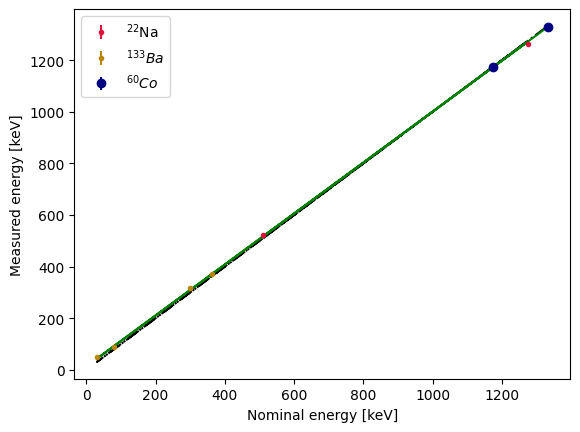

In [297]:
en_ch_=en_ch_7
ch_=ch_7
sigma_ch_=sigma_ch_7
par=par7

plt.errorbar(en_ch_, retta(en_ch_, par[0], par[1]), color='green')
plt.errorbar(en_ch_[0:2], ch_[0:2], yerr=sigma_ch_[0:2], ls='', marker='.', color='crimson', label='$^{22}$Na')
plt.errorbar(en_ch_[2:6], ch_[2:6], yerr=sigma_ch_[2:6], ls='', marker='.', color='darkgoldenrod', label='$^{133}Ba$')
plt.errorbar(en_ch_[6:], ch_[6:], yerr=sigma_ch_[6:], ls='', marker='o', color='navy', label='$^{60}Co$')
plt.plot(en_ch_, en_ch_, ls='-.', color='black')
plt.xlabel("Nominal energy [keV]")
plt.ylabel("Measured energy [keV]")
plt.legend()  # Add legend for each subplot




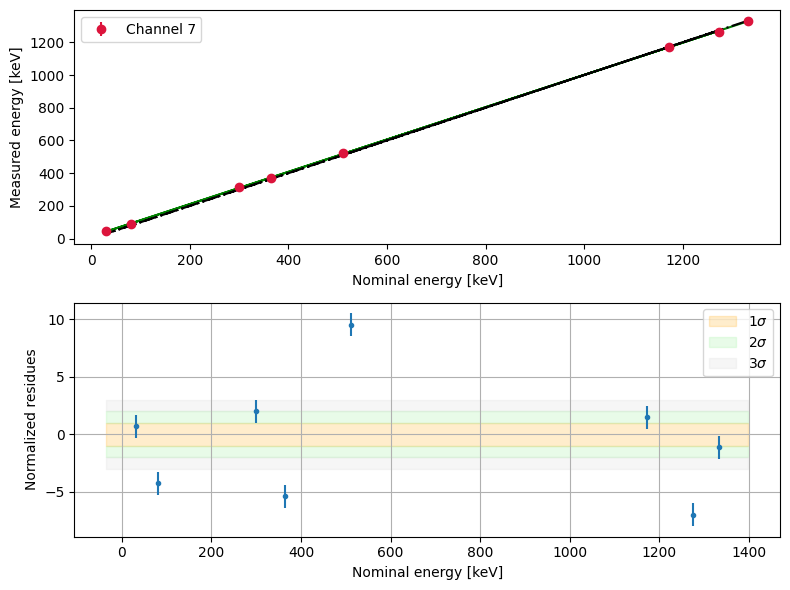

[ 4.57713232 -9.65246159  4.26661639 -3.22651041  8.2647571  -2.76166468
  0.92661311 -0.73229344]


In [298]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.errorbar(en_ch_, ch_, yerr=sigma_ch_, ls='', marker='o', color='crimson', label='Channel {}'.format(ch))
ax1.plot(en_ch_, retta(en_ch_,par[0], par[1]), color='green')
ax1.plot(en_ch_, en_ch_, ls='-.', color='black')
ax1.set_xlabel("Nominal energy [keV]")
ax1.set_ylabel("Measured energy [keV]")
ax1.legend()  # Add legend for each subplot

residue= ch_- retta(en_ch_, par[0], par[1])
norm_res = residue / sigma_ch_

ax2.errorbar(en_ch_, norm_res, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Nominal energy [keV]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()
print(residue)

In [52]:
#kolmogorov smirnov
print(' ')
print('Test del K-S per il set 2')
t2=[]
valori=residue
N=len(valori)
media=np.mean(valori)
sigma=np.std(valori)
for j in range(0,N):
  t2.append((valori[j] - media)/sigma)
t2=sorted(t2)
print(t2)

 
Test del K-S per il set 2
[-1.5168532918267075, -0.7892323386254833, 0.4540483347166349, 0.647551913691549, 1.2044853820440067]


In [42]:
diff=[]
cumulata=[0.167, 0.167*2, 0.167*3, 0.167*4, 0.167*5, 1]
#devi metterci i valori che ottieni facendo 1/N e sommandoli
#in t2 devi mettere i valori di t ottenuti con distcalc
#devi mettere 1-alpha di distcalc
t=[1-0.98228, 1-0.57146, 1-0.39718, 1-0.2967, 1-0.29416, 1-0.17168]
for i in range(0,N):
  diff.append(cumulata[i]-t[i])
print(f'differenza={diff}')
#cerca il valore nella tabella
print(min(diff))
print(max(diff))
#la significatività è superiore al 20%

differenza=[0.14928000000000005, -0.09454000000000001, -0.10182000000000002, -0.0353]
-0.10182000000000002
0.14928000000000005


### ch 8

In [34]:
ch=8
ch_8=np.abs([peak_e[ch], peak_f[ch], -170.824, -666.152, -2170.299, -2453.222])/coeff_cal[ch]*energia
en_ch_8=np.array([511, 1274, 81,  (356.02*0.738+383.9*0.317)/(0.317+0.738), 1173.2, 1332.5])
#en_ch_3=np.array([511, 1274, 30.85, 81, (356.02*0.738+383.9*0.317)/(0.317+0.738), (276.4*0.088+302.85*0.666)/(0.088+0.666)])
sigma_ch_8=[sigma_e[ch], sigma_f[ch], 1.117, 1.321, 2.320, 2.595]/coeff_cal[ch]*energia
par8, cov8= curve_fit(retta, en_ch_8, ch_8, sigma=sigma_ch_8)
print(par8, np.sqrt(cov8[0][0]), np.sqrt(cov8[1][1]))

[ 0.98854942 15.25789408] 0.010647415163188663 7.212283020232888


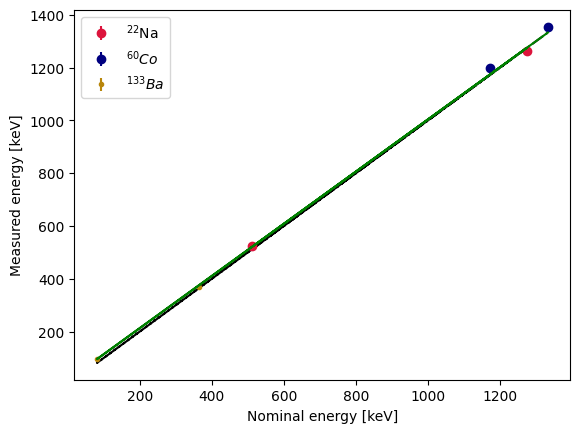

In [35]:
en_ch_=en_ch_8
ch_=ch_8
sigma_ch_=sigma_ch_8
par=par8
plt.errorbar(en_ch_[0:2], ch_[0:2], yerr=sigma_ch_[0:2], ls='', marker='o', color='crimson', label='$^{22}$Na')
plt.errorbar(en_ch_[4:], ch_[4:], yerr=sigma_ch_[4:], ls='', marker='o', color='navy', label='$^{60}Co$')
plt.errorbar(en_ch_[2:4], ch_[2:4], yerr=sigma_ch_[2:4], ls='', marker='.', color='darkgoldenrod', label='$^{133}Ba$')
plt.errorbar(en_ch_, retta(en_ch_, par[0], par[1]), color='green')
plt.plot(en_ch_, en_ch_, ls='-.', color='black')
plt.xlabel("Nominal energy [keV]")
plt.ylabel("Measured energy [keV]")
plt.legend()  # Add legend for each subplot

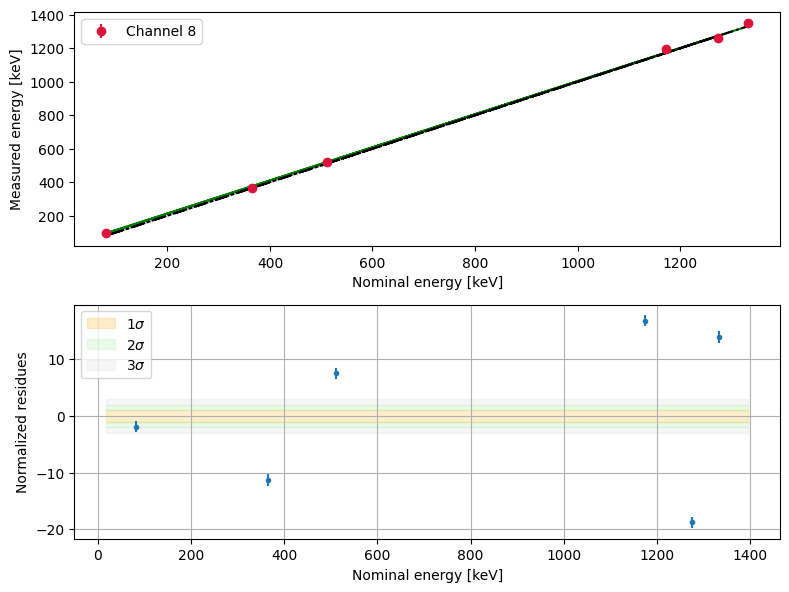

[  2.54620929 -13.25468392  -1.15599209  -8.23632817  21.45076015
  19.94885282]


In [36]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.errorbar(en_ch_, ch_, yerr=sigma_ch_, ls='', marker='o', color='crimson', label='Channel {}'.format(ch))
ax1.plot(en_ch_, retta(en_ch_,par[0], par[1]), color='green')
ax1.plot(en_ch_, en_ch_, ls='-.', color='black')
ax1.set_xlabel("Nominal energy [keV]")
ax1.set_ylabel("Measured energy [keV]")
ax1.legend()  # Add legend for each subplot

residue= ch_- retta(en_ch_, par[0], par[1])
norm_res = residue / sigma_ch_

ax2.errorbar(en_ch_, norm_res, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Nominal energy [keV]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()
print(residue)

In [136]:
#kolmogorov smirnov
print(' ')
print('Test del K-S per il set 2')
t2=[]
valori=residue
N=len(valori)
media=np.mean(valori)
sigma=np.std(valori)
for j in range(0,N):
  t2.append((valori[j] - media)/sigma)
t2=sorted(t2)
print(t2)

 
Test del K-S per il set 2
[-1.1479168228641323, -0.28137208532198216, -0.17464833398496016, 1.6039372421710747]


In [ ]:
diff=[]
cumulata=[0.167, 0.167*2, 0.167*3, 0.167*4, 0.167*5, 1]
#devi metterci i valori che ottieni facendo 1/N e sommandoli
#in t2 devi mettere i valori di t ottenuti con distcalc
#devi mettere 1-alpha di distcalc
t=[1-0.98228, 1-0.57146, 1-0.39718, 1-0.2967, 1-0.29416, 1-0.17168]
for i in range(0,N):
  diff.append(cumulata[i]-t[i])
print(f'differenza={diff}')
#cerca il valore nella tabella
print(min(diff))
print(max(diff))
#la significatività è superiore al 20%

### ch 9

In [198]:
ch=9
ch_9=np.abs([peak_e[ch], peak_f[ch], -98.190, -362.576])/coeff_cal[ch]*energia
en_ch_9=np.array([511, 1274, 81, (356.02*0.738+383.9*0.317)/(0.317+0.738),  1173.2, 1332.5])
#en_ch_3=np.array([511, 1274, 30.85, 81, (356.02*0.738+383.9*0.317)/(0.317+0.738), (276.4*0.088+302.85*0.666)/(0.088+0.666)])
sigma_ch_9=[sigma_e[ch], sigma_f[ch], 0.283, 0.501]/coeff_cal[ch]*energia
par9, cov9= curve_fit(retta, en_ch_9, ch_9, sigma=sigma_ch_9)
print(par9, np.sqrt(cov9[0][0]), np.sqrt(cov9[1][1]))

[ 0.94624435 22.18996841] 0.00395389705748712 1.152725665209877


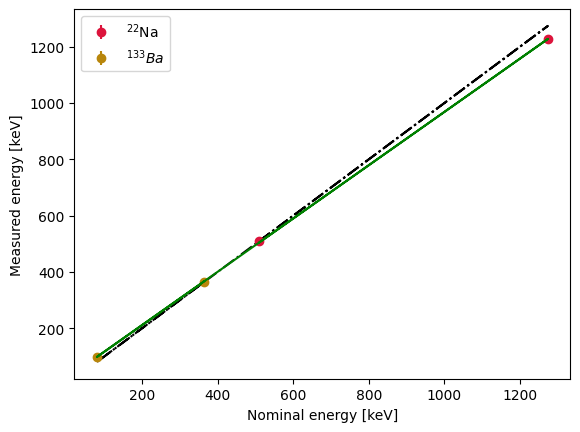

In [199]:
en_ch_=en_ch_9
ch_=ch_9
sigma_ch_=sigma_ch_9
par=par9
plt.errorbar(en_ch_[0:2], ch_[0:2], yerr=sigma_ch_[0:2], ls='', marker='o', color='crimson', label='$^{22}$Na')
plt.errorbar(en_ch_[2:4], ch_[2:4], yerr=sigma_ch_[2:4], ls='', marker='o', color='darkgoldenrod', label='$^{133}Ba$')
plt.errorbar(en_ch_[4:], ch_[4:], yerr=sigma_ch_[4:], ls='', marker='o', color='navy', label='$^{60}Co$')
plt.errorbar(en_ch_, retta(en_ch_, par[0], par[1]), color='green')
plt.plot(en_ch_, en_ch_, ls='-.', color='black')
plt.xlabel("Nominal energy [keV]")
plt.ylabel("Measured energy [keV]")
plt.legend()  # Add legend for each subplot

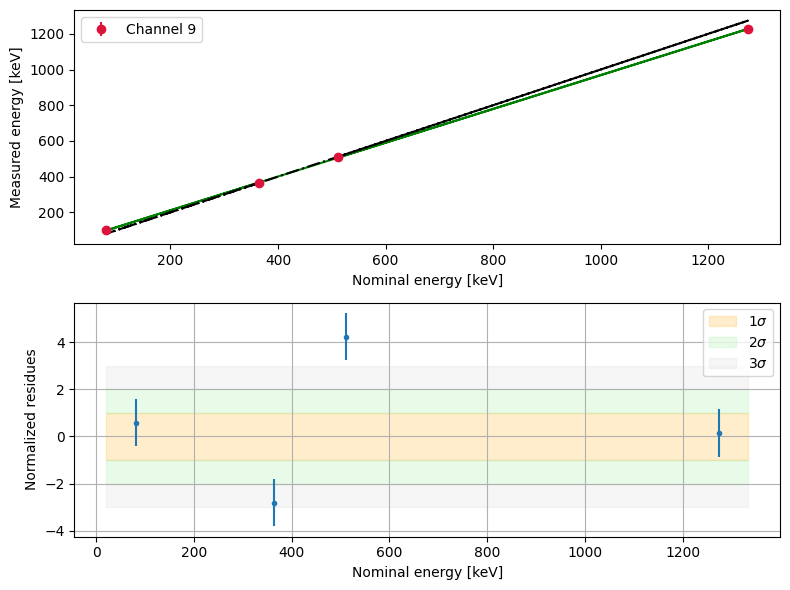

[ 5.27916665  0.22026315  0.16796819 -1.41800063]


In [200]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.errorbar(en_ch_, ch_, yerr=sigma_ch_, ls='', marker='o', color='crimson', label='Channel {}'.format(ch))
ax1.plot(en_ch_, retta(en_ch_,par[0], par[1]), color='green')
ax1.plot(en_ch_, en_ch_, ls='-.', color='black')
ax1.set_xlabel("Nominal energy [keV]")
ax1.set_ylabel("Measured energy [keV]")
ax1.legend()  # Add legend for each subplot

residue= ch_- retta(en_ch_, par[0], par[1])
norm_res = residue / sigma_ch_

ax2.errorbar(en_ch_, norm_res, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Nominal energy [keV]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()
print(residue)

In [ ]:
#kolmogorov smirnov
print(' ')
print('Test del K-S per il set 2')
t2=[]
valori=residue
N=len(valori)
media=np.mean(valori)
sigma=np.std(valori)
for j in range(0,N):
  t2.append((valori[j] - media)/sigma)
t2=sorted(t2)
print(t2)

In [ ]:
diff=[]
cumulata=[0.167, 0.167*2, 0.167*3, 0.167*4, 0.167*5, 1]
#devi metterci i valori che ottieni facendo 1/N e sommandoli
#in t2 devi mettere i valori di t ottenuti con distcalc
#devi mettere 1-alpha di distcalc
t=[1-0.98228, 1-0.57146, 1-0.39718, 1-0.2967, 1-0.29416, 1-0.17168]
for i in range(0,N):
  diff.append(cumulata[i]-t[i])
print(f'differenza={diff}')
#cerca il valore nella tabella
print(min(diff))
print(max(diff))
#la significatività è superiore al 20%

### ch 10

In [224]:
ch=10
ch_10=np.abs([peak_e[ch], peak_f[ch], -79.969, -305.726])/coeff_cal[ch]*energia
en_ch_10=np.array([511, 1274, 81, (356.02*0.738+383.9*0.317)/(0.317+0.738)])
#en_ch_3=np.array([511, 1274, 30.85, 81, (356.02*0.738+383.9*0.317)/(0.317+0.738), (276.4*0.088+302.85*0.666)/(0.088+0.666)])
sigma_ch_10=[sigma_e[ch], sigma_f[ch], 0.349, 0.854]/coeff_cal[ch]*energia
par10, cov10= curve_fit(retta, en_ch_10, ch_10, sigma=sigma_ch_10)
print(par10, np.sqrt(cov10[0][0]), np.sqrt(cov10[1][1]))

[ 0.95911739 16.23453356] 0.008388292062345072 3.824342567540832


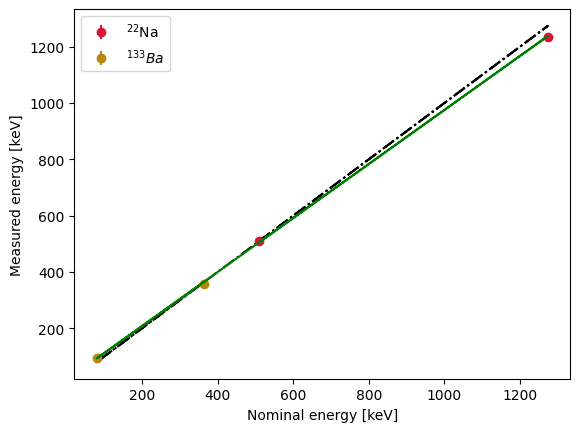

In [225]:
en_ch_=en_ch_10
ch_=ch_10
sigma_ch_=sigma_ch_10
par=par10
plt.errorbar(en_ch_[0:2], ch_[0:2], yerr=sigma_ch_[0:2], ls='', marker='o', color='crimson', label='$^{22}$Na')
plt.errorbar(en_ch_[2:], ch_[2:], yerr=sigma_ch_[2:], ls='', marker='o', color='darkgoldenrod', label='$^{133}Ba$')
plt.errorbar(en_ch_, retta(en_ch_, par[0], par[1]), color='green')
plt.plot(en_ch_, en_ch_, ls='-.', color='black')
plt.xlabel("Nominal energy [keV]")
plt.ylabel("Measured energy [keV]")
plt.legend()  # Add legend for each subplot

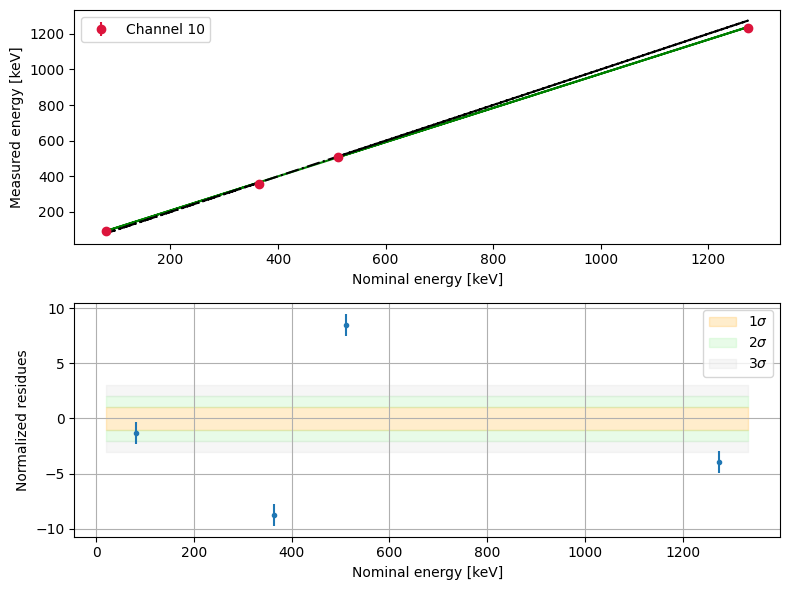

[ 4.65647801 -4.47893735 -0.53867444 -8.72053005]


In [226]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.errorbar(en_ch_, ch_, yerr=sigma_ch_, ls='', marker='o', color='crimson', label='Channel {}'.format(ch))
ax1.plot(en_ch_, retta(en_ch_,par[0], par[1]), color='green')
ax1.plot(en_ch_, en_ch_, ls='-.', color='black')
ax1.set_xlabel("Nominal energy [keV]")
ax1.set_ylabel("Measured energy [keV]")
ax1.legend()  # Add legend for each subplot

residue= ch_- retta(en_ch_, par[0], par[1])
norm_res = residue / sigma_ch_

ax2.errorbar(en_ch_, norm_res, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Nominal energy [keV]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()
print(residue)

In [ ]:
#kolmogorov smirnov
print(' ')
print('Test del K-S per il set 2')
t2=[]
valori=residue
N=len(valori)
media=np.mean(valori)
sigma=np.std(valori)
for j in range(0,N):
  t2.append((valori[j] - media)/sigma)
t2=sorted(t2)
print(t2)

In [ ]:
diff=[]
cumulata=[0.167, 0.167*2, 0.167*3, 0.167*4, 0.167*5, 1]
#devi metterci i valori che ottieni facendo 1/N e sommandoli
#in t2 devi mettere i valori di t ottenuti con distcalc
#devi mettere 1-alpha di distcalc
t=[1-0.98228, 1-0.57146, 1-0.39718, 1-0.2967, 1-0.29416, 1-0.17168]
for i in range(0,N):
  diff.append(cumulata[i]-t[i])
print(f'differenza={diff}')
#cerca il valore nella tabella
print(min(diff))
print(max(diff))
#la significatività è superiore al 20%

### ch 11

In [254]:
ch=11
ch_11=np.abs([peak_e[ch], peak_f[ch], -124.268, -511.263])/coeff_cal[ch]*energia
en_ch_11=np.array([511, 1274, 81, (356.02*0.738+383.9*0.317)/(0.317+0.738)])
#en_ch_3=np.array([511, 1274, 30.85, 81, (356.02*0.738+383.9*0.317)/(0.317+0.738), (276.4*0.088+302.85*0.666)/(0.088+0.666)])
sigma_ch_11=[sigma_e[ch], sigma_f[ch], 0.508, 2.282]/coeff_cal[ch]*energia
par11, cov11= curve_fit(retta, en_ch_11, ch_11, sigma=sigma_ch_11)
print(par11, np.sqrt(cov11[0][0]), np.sqrt(cov11[1][1]))

[0.98437938 2.2217981 ] 0.013780575550479582 4.921839795859851


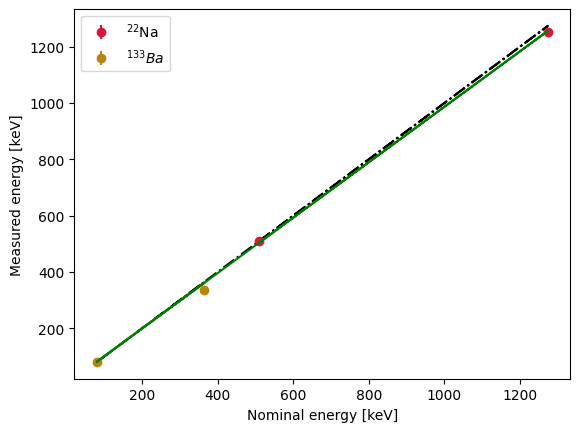

In [255]:
en_ch_=en_ch_11
ch_=ch_11
sigma_ch_=sigma_ch_11
par=par11
plt.errorbar(en_ch_[0:2], ch_[0:2], yerr=sigma_ch_[0:2], ls='', marker='o', color='crimson', label='$^{22}$Na')
plt.errorbar(en_ch_[2:], ch_[2:], yerr=sigma_ch_[2:], ls='', marker='o', color='darkgoldenrod', label='$^{133}Ba$')
plt.errorbar(en_ch_, retta(en_ch_, par[0], par[1]), color='green')
plt.plot(en_ch_, en_ch_, ls='-.', color='black')
plt.xlabel("Nominal energy [keV]")
plt.ylabel("Measured energy [keV]")
plt.legend()  # Add legend for each subplot

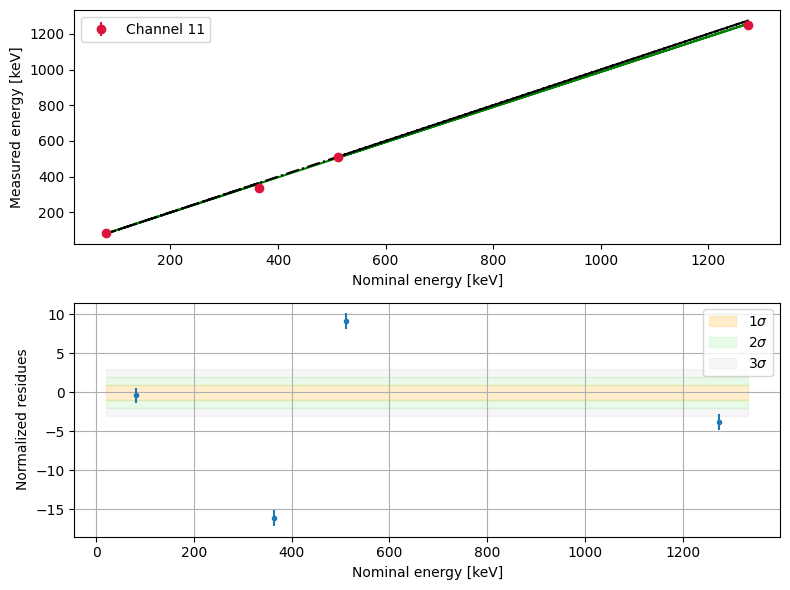

[  5.76033926  -5.44303605  -0.12583104 -24.25931511]


In [256]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.errorbar(en_ch_, ch_, yerr=sigma_ch_, ls='', marker='o', color='crimson', label='Channel {}'.format(ch))
ax1.plot(en_ch_, retta(en_ch_,par[0], par[1]), color='green')
ax1.plot(en_ch_, en_ch_, ls='-.', color='black')
ax1.set_xlabel("Nominal energy [keV]")
ax1.set_ylabel("Measured energy [keV]")
ax1.legend()  # Add legend for each subplot

residue= ch_- retta(en_ch_, par[0], par[1])
norm_res = residue / sigma_ch_

ax2.errorbar(en_ch_, norm_res, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Nominal energy [keV]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()
print(residue)

In [ ]:
#kolmogorov smirnov
print(' ')
print('Test del K-S per il set 2')
t2=[]
valori=residue
N=len(valori)
media=np.mean(valori)
sigma=np.std(valori)
for j in range(0,N):
  t2.append((valori[j] - media)/sigma)
t2=sorted(t2)
print(t2)

In [ ]:
diff=[]
cumulata=[0.167, 0.167*2, 0.167*3, 0.167*4, 0.167*5, 1]
#devi metterci i valori che ottieni facendo 1/N e sommandoli
#in t2 devi mettere i valori di t ottenuti con distcalc
#devi mettere 1-alpha di distcalc
t=[1-0.98228, 1-0.57146, 1-0.39718, 1-0.2967, 1-0.29416, 1-0.17168]
for i in range(0,N):
  diff.append(cumulata[i]-t[i])
print(f'differenza={diff}')
#cerca il valore nella tabella
print(min(diff))
print(max(diff))
#la significatività è superiore al 20%

### ch 12

In [14]:
ch=12
ch_12=np.abs([peak_e[ch], peak_f[ch], -133.19, -538.702])/coeff_cal[ch]*energia
en_ch_12=np.array([511, 1274, 81, (356.02*0.738+383.9*0.317)/(0.317+0.738)])
#en_ch_3=np.array([511, 1274, 30.85, 81, (356.02*0.738+383.9*0.317)/(0.317+0.738), (276.4*0.088+302.85*0.666)/(0.088+0.666)])
sigma_ch_12=[sigma_e[ch], sigma_f[ch],0.668, 1.556]/coeff_cal[ch]*energia
par12, cov12= curve_fit(retta, en_ch_12, ch_12, sigma=sigma_ch_12)
print(par12, np.sqrt(cov12[0][0]), np.sqrt(cov12[1][1]))

[ 0.98778952 19.85269205] 0.01662011117248409 6.2231235369772735


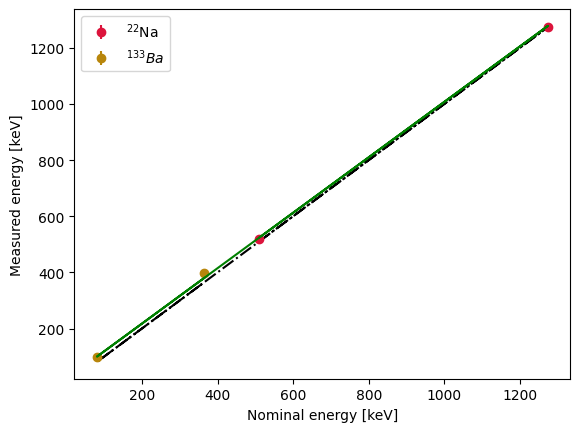

In [15]:
en_ch_=en_ch_12
ch_=ch_12
sigma_ch_=sigma_ch_12
par=par12
plt.errorbar(en_ch_[0:2], ch_[0:2], yerr=sigma_ch_[0:2], ls='', marker='o', color='crimson', label='$^{22}$Na')
plt.errorbar(en_ch_[2:], ch_[2:], yerr=sigma_ch_[2:], ls='', marker='o', color='darkgoldenrod', label='$^{133}Ba$')
plt.errorbar(en_ch_, retta(en_ch_, par[0], par[1]), color='green')
plt.plot(en_ch_, en_ch_, ls='-.', color='black')
plt.xlabel("Nominal energy [keV]")
plt.ylabel("Measured energy [keV]")
plt.legend()  # Add legend for each subplot

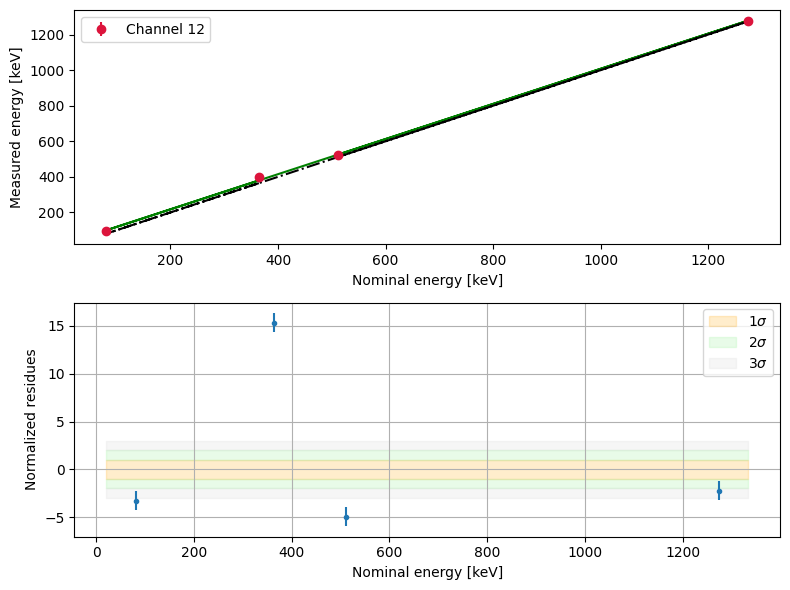

[-4.35028388 -4.29654349 -1.60674663 17.61067652]


In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.errorbar(en_ch_, ch_, yerr=sigma_ch_, ls='', marker='o', color='crimson', label='Channel {}'.format(ch))
ax1.plot(en_ch_, retta(en_ch_,par[0], par[1]), color='green')
ax1.plot(en_ch_, en_ch_, ls='-.', color='black')
ax1.set_xlabel("Nominal energy [keV]")
ax1.set_ylabel("Measured energy [keV]")
ax1.legend()  # Add legend for each subplot

residue= ch_- retta(en_ch_, par[0], par[1])
norm_res = residue / sigma_ch_

ax2.errorbar(en_ch_, norm_res, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Nominal energy [keV]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()
print(residue)

In [ ]:
#kolmogorov smirnov
print(' ')
print('Test del K-S per il set 2')
t2=[]
valori=residue
N=len(valori)
media=np.mean(valori)
sigma=np.std(valori)
for j in range(0,N):
  t2.append((valori[j] - media)/sigma)
t2=sorted(t2)
print(t2)

In [ ]:
diff=[]
cumulata=[0.167, 0.167*2, 0.167*3, 0.167*4, 0.167*5, 1]
#devi metterci i valori che ottieni facendo 1/N e sommandoli
#in t2 devi mettere i valori di t ottenuti con distcalc
#devi mettere 1-alpha di distcalc
t=[1-0.98228, 1-0.57146, 1-0.39718, 1-0.2967, 1-0.29416, 1-0.17168]
for i in range(0,N):
  diff.append(cumulata[i]-t[i])
print(f'differenza={diff}')
#cerca il valore nella tabella
print(min(diff))
print(max(diff))
#la significatività è superiore al 20%

### ch 13

In [ ]:
ch=13
ch_13=np.abs([peak_e[ch], peak_f[ch]])/coeff_cal[ch]*energia
en_ch_13=np.array([511, 1274, ])
#en_ch_3=np.array([511, 1274, 30.85, 81, (356.02*0.738+383.9*0.317)/(0.317+0.738), (276.4*0.088+302.85*0.666)/(0.088+0.666)])
sigma_ch_13=[sigma_e[ch], sigma_f[ch]]/coeff_cal[ch]*energia
par13, cov13= curve_fit(retta, en_ch_13, ch_13, sigma=sigma_ch_13)
print(par13, np.sqrt(cov13[0][0]), np.sqrt(cov13[1][1]))

In [ ]:
en_ch_=en_ch_13
ch_=ch_13
sigma_ch_=sigma_ch_13
par=par13
plt.errorbar(en_ch_[0:2], ch_[0:2], yerr=sigma_ch_[0:2], ls='', marker='o', color='crimson', label='$^{22}$Na')
plt.errorbar(en_ch_[2:], ch_[2:], yerr=sigma_ch_[2:], ls='', marker='o', color='darkgoldenrod', label='$^{133}Ba$')
plt.errorbar(en_ch_, retta(en_ch_, par[0], par[1]), color='green')
plt.plot(en_ch_, en_ch_, ls='-.', color='black')
plt.xlabel("Nominal energy [keV]")
plt.ylabel("Measured energy [keV]")
plt.legend()  # Add legend for each subplot

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.errorbar(en_ch_, ch_, yerr=sigma_ch_, ls='', marker='o', color='crimson', label='Channel {}'.format(ch))
ax1.plot(en_ch_, retta(en_ch_,par[0], par[1]), color='green')
ax1.plot(en_ch_, en_ch_, ls='-.', color='black')
ax1.set_xlabel("Nominal energy [keV]")
ax1.set_ylabel("Measured energy [keV]")
ax1.legend()  # Add legend for each subplot

residue= ch_- retta(en_ch_, par[0], par[1])
norm_res = residue / sigma_ch_

ax2.errorbar(en_ch_, norm_res, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Nominal energy [keV]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()
print(residue)

In [ ]:
#kolmogorov smirnov
print(' ')
print('Test del K-S per il set 2')
t2=[]
valori=residue
N=len(valori)
media=np.mean(valori)
sigma=np.std(valori)
for j in range(0,N):
  t2.append((valori[j] - media)/sigma)
t2=sorted(t2)
print(t2)

In [ ]:
diff=[]
cumulata=[0.167, 0.167*2, 0.167*3, 0.167*4, 0.167*5, 1]
#devi metterci i valori che ottieni facendo 1/N e sommandoli
#in t2 devi mettere i valori di t ottenuti con distcalc
#devi mettere 1-alpha di distcalc
t=[1-0.98228, 1-0.57146, 1-0.39718, 1-0.2967, 1-0.29416, 1-0.17168]
for i in range(0,N):
  diff.append(cumulata[i]-t[i])
print(f'differenza={diff}')
#cerca il valore nella tabella
print(min(diff))
print(max(diff))
#la significatività è superiore al 20%

### ch 14

In [371]:
ch=14
ch_14=np.abs([peak_e[ch], peak_f[ch], -83.928,  -184.194, -777.060])/coeff_cal[ch]*energia
en_ch_14=np.array([511, 1274, 30.85, 81, (356.02*0.738+383.9*0.317)/(0.317+0.738)])
#en_ch_3=np.array([511, 1274, 30.85, 81, (356.02*0.738+383.9*0.317)/(0.317+0.738), (276.4*0.088+302.85*0.666)/(0.088+0.666)])
sigma_ch_14=[sigma_e[ch], sigma_f[ch], 1.30, 0.634, 0.558]/coeff_cal[ch]*energia
par14, cov14= curve_fit(retta, en_ch_14, ch_14, sigma=sigma_ch_14)
print(par14, np.sqrt(cov14[0][0]), np.sqrt(cov14[1][1]))

[0.97271661 5.74469479] 0.00943796963543412 3.3422696270159187


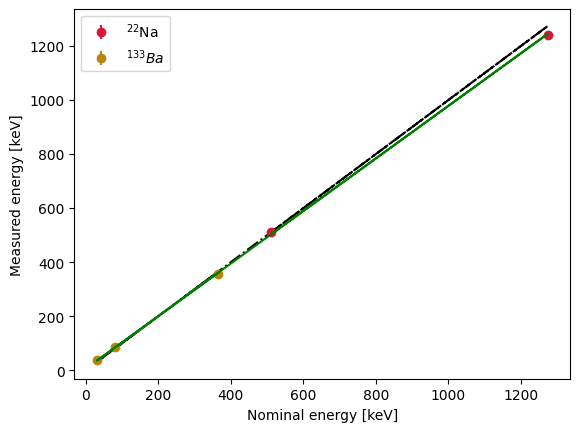

In [372]:
en_ch_=en_ch_14
ch_=ch_14
sigma_ch_=sigma_ch_14
par=par14
plt.errorbar(en_ch_[0:2], ch_[0:2], yerr=sigma_ch_[0:2], ls='', marker='o', color='crimson', label='$^{22}$Na')
plt.errorbar(en_ch_[2:], ch_[2:], yerr=sigma_ch_[2:], ls='', marker='o', color='darkgoldenrod', label='$^{133}Ba$')
plt.errorbar(en_ch_, retta(en_ch_, par[0], par[1]), color='green')
plt.plot(en_ch_, en_ch_, ls='-.', color='black')
plt.xlabel("Nominal energy [keV]")
plt.ylabel("Measured energy [keV]")
plt.legend()  # Add legend for each subplot

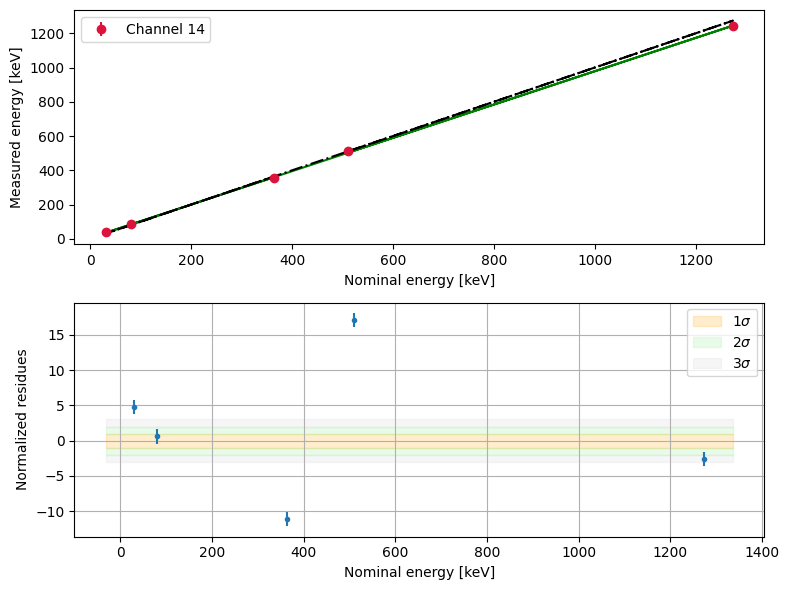

[ 8.19711568 -3.16000371  2.84264038  0.16983739 -2.85636029]


In [373]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.errorbar(en_ch_, ch_, yerr=sigma_ch_, ls='', marker='o', color='crimson', label='Channel {}'.format(ch))
ax1.plot(en_ch_, retta(en_ch_,par[0], par[1]), color='green')
ax1.plot(en_ch_, en_ch_, ls='-.', color='black')
ax1.set_xlabel("Nominal energy [keV]")
ax1.set_ylabel("Measured energy [keV]")
ax1.legend()  # Add legend for each subplot

residue= ch_- retta(en_ch_, par[0], par[1])
norm_res = residue / sigma_ch_

ax2.errorbar(en_ch_, norm_res, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Nominal energy [keV]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()
print(residue)

In [ ]:
diff=[]
cumulata=[0.167, 0.167*2, 0.167*3, 0.167*4, 0.167*5, 1]
#devi metterci i valori che ottieni facendo 1/N e sommandoli
#in t2 devi mettere i valori di t ottenuti con distcalc
#devi mettere 1-alpha di distcalc
t=[1-0.98228, 1-0.57146, 1-0.39718, 1-0.2967, 1-0.29416, 1-0.17168]
for i in range(0,N):
  diff.append(cumulata[i]-t[i])
print(f'differenza={diff}')
#cerca il valore nella tabella
print(min(diff))
print(max(diff))
#la significatività è superiore al 20%

### ch 15

In [11]:
ch=15
ch_15=np.abs([peak_e[ch], peak_f[ch], -112.397, -265.353, -925.429, -1088.382])/coeff_cal[ch]*energia
en_ch_15=np.array([511, 1274, 30.85, 81, (276.4*0.088+302.85*0.666)/(0.088+0.666), (356.02*0.738+383.9*0.317)/(0.317+0.738)])
#en_ch_3=np.array([511, 1274, 30.85, 81, (356.02*0.738+383.9*0.317)/(0.317+0.738), (276.4*0.088+302.85*0.666)/(0.088+0.666)])
sigma_ch_15=[sigma_e[ch], sigma_f[ch], 0.973, 1.021, 5.45, 1.114]/coeff_cal[ch]*energia
par15, cov15= curve_fit(retta, en_ch_15, ch_15, sigma=sigma_ch_15)
print(par15, np.sqrt(cov15[0][0]), np.sqrt(cov15[1][1]))

[0.99898061 5.89885635] 0.014093172307418876 4.28187309589528


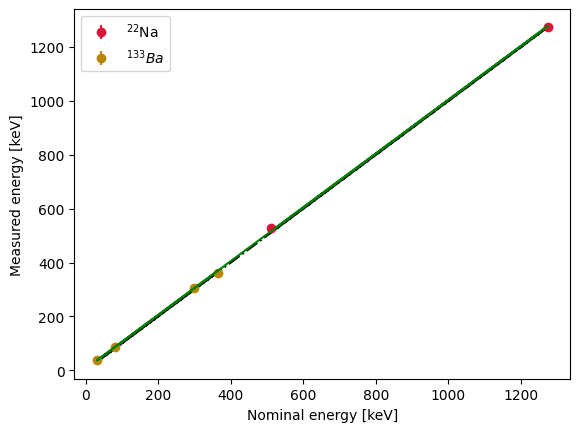

In [12]:
en_ch_=en_ch_15
ch_=ch_15
sigma_ch_=sigma_ch_15
par=par15
plt.errorbar(en_ch_[0:2], ch_[0:2], yerr=sigma_ch_[0:2], ls='', marker='o', color='crimson', label='$^{22}$Na')
plt.errorbar(en_ch_[2:], ch_[2:], yerr=sigma_ch_[2:], ls='', marker='o', color='darkgoldenrod', label='$^{133}Ba$')
plt.errorbar(en_ch_, retta(en_ch_, par[0], par[1]), color='green')
plt.plot(en_ch_, en_ch_, ls='-.', color='black')
plt.xlabel("Nominal energy [keV]")
plt.ylabel("Measured energy [keV]")
plt.legend()  # Add legend for each subplot

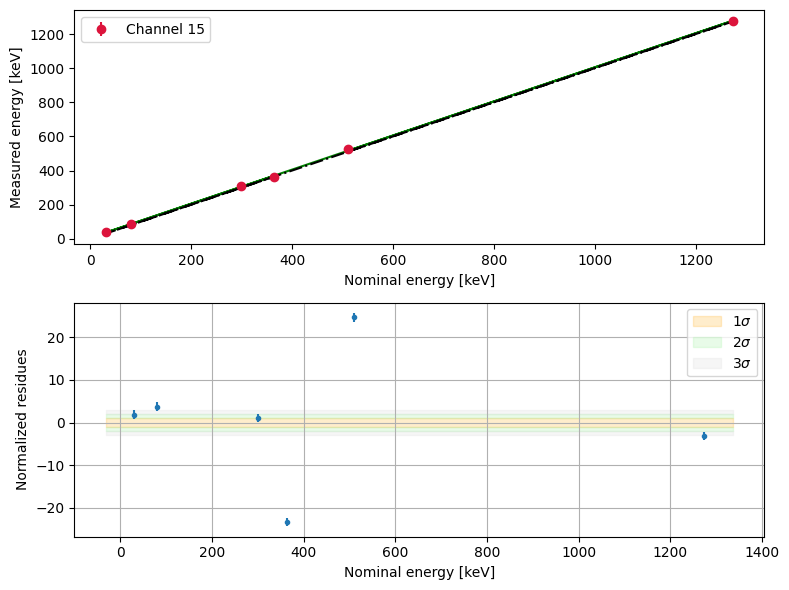

[12.74933607 -4.60014811  0.5956772   1.27449199  1.86376587 -8.60810796]


In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.errorbar(en_ch_, ch_, yerr=sigma_ch_, ls='', marker='o', color='crimson', label='Channel {}'.format(ch))
ax1.plot(en_ch_, retta(en_ch_,par[0], par[1]), color='green')
ax1.plot(en_ch_, en_ch_, ls='-.', color='black')
ax1.set_xlabel("Nominal energy [keV]")
ax1.set_ylabel("Measured energy [keV]")
ax1.legend()  # Add legend for each subplot

residue= ch_- retta(en_ch_, par[0], par[1])
norm_res = residue / sigma_ch_

ax2.errorbar(en_ch_, norm_res, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Nominal energy [keV]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()
print(residue)

In [ ]:
#kolmogorov smirnov
print(' ')
print('Test del K-S per il set 2')
t2=[]
valori=residue
N=len(valori)
media=np.mean(valori)
sigma=np.std(valori)
for j in range(0,N):
  t2.append((valori[j] - media)/sigma)
t2=sorted(t2)
print(t2)

In [ ]:
diff=[]
cumulata=[0.167, 0.167*2, 0.167*3, 0.167*4, 0.167*5, 1]
#devi metterci i valori che ottieni facendo 1/N e sommandoli
#in t2 devi mettere i valori di t ottenuti con distcalc
#devi mettere 1-alpha di distcalc
t=[1-0.98228, 1-0.57146, 1-0.39718, 1-0.2967, 1-0.29416, 1-0.17168]
for i in range(0,N):
  diff.append(cumulata[i]-t[i])
print(f'differenza={diff}')
#cerca il valore nella tabella
print(min(diff))
print(max(diff))
#la significatività è superiore al 20%

In [ ]:
ch=np.arange(0,16,step=1)
colors = ['blue', 'green', 'red', 'orange', 'purple', 'cyan', 'magenta', 'gold', 'crimson', 'pink', 'brown', 'gray', 'orchid', 'navy', 
          'seagreen', 'goldenrod']

# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 16))#, sharex=True)
ref_g=peak_e[channel_ref]
energia=511/ref_g
energy_g=peak_e/coeff_cal*energia
sigma_g=new_sigma_e/coeff_cal*energia
ref_f=peak_f[channel_ref]
energy_f=test_peak_centers*energia
sigma_f=test_peak_errors*energia
# Iterate over each element in channels
for j, color in enumerate(colors):
    # Calculate subplot row and column
    row = j // 4
    col = j % 4
    
    # Plot error bars on the corresponding subplot with different color
    axes[row, col].errorbar(energy, np.array([energy_g[j], energy_f[j]]), yerr=np.array([sigma_g[j], sigma_f[j]]), 
                            ls='', marker='o', color=color, label='Channel {}'.format(j))

   

    axes[row, col].errorbar(energy, energy, ls='--', color='black')
    
    axes[row, col].set_xlabel("Nominal energy [keV]")
    axes[row, col].set_ylabel("Measured energy [keV]")
    axes[row, col].legend(fontsize='small')  # Add legend for each subplot